In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
# Problem parameters
NUM_CUSTOMERS = 20
NUM_VEHICLES = 3
VEHICLE_CAPACITY = 50
DEPOT = (50, 50)  # Centered depot

# Generate customer data
np.random.seed(42)
customer_locations = np.random.rand(NUM_CUSTOMERS, 2) * 100
customer_demands = np.random.randint(1, 20, NUM_CUSTOMERS)


In [3]:
# Distance matrix
def euclidean_distance(a, b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [4]:

distance_matrix = np.zeros((NUM_CUSTOMERS+1, NUM_CUSTOMERS+1))
for i in range(NUM_CUSTOMERS+1):
    for j in range(NUM_CUSTOMERS+1):
        loc_i = DEPOT if i == 0 else customer_locations[i-1]
        loc_j = DEPOT if j == 0 else customer_locations[j-1]
        distance_matrix[i, j] = euclidean_distance(loc_i, loc_j)

In [5]:

# Genetic Algorithm Implementation
class GeneticAlgorithmVRP:
    def __init__(self, pop_size=100, elite_size=10, mutation_rate=0.2, generations=200):
        self.pop_size = pop_size
        self.elite_size = elite_size
        self.mutation_rate = mutation_rate
        self.generations = generations
    
    def create_individual(self):
        """Create random customer permutation"""
        return random.sample(range(NUM_CUSTOMERS), NUM_CUSTOMERS)
    
    def decode_route(self, individual):
        """Convert permutation into vehicle routes"""
        routes = [[] for _ in range(NUM_VEHICLES)]
        loads = [0] * NUM_VEHICLES
        vehicle_idx = 0
        
        for customer in individual:
            demand = customer_demands[customer]
            while loads[vehicle_idx] + demand > VEHICLE_CAPACITY:
                vehicle_idx = (vehicle_idx + 1) % NUM_VEHICLES
            routes[vehicle_idx].append(customer)
            loads[vehicle_idx] += demand
            vehicle_idx = (vehicle_idx + 1) % NUM_VEHICLES
            
        return routes
    
    def route_distance(self, route):
        """Calculate distance for a single route"""
        if not route: return 0
        dist = distance_matrix[0, route[0]+1]  # Depot to first customer
        for i in range(len(route)-1):
            dist += distance_matrix[route[i]+1, route[i+1]+1]
        dist += distance_matrix[route[-1]+1, 0]  # Last customer to depot
        return dist
    
    def fitness(self, individual):
        """Calculate total distance for all vehicles"""
        routes = self.decode_route(individual)
        return sum(self.route_distance(route) for route in routes)
    
    def rank_population(self, population):
        """Sort population by fitness"""
        return sorted(population, key=self.fitness)
    
    def selection(self, ranked_pop):
        """Tournament selection"""
        selection_size = self.pop_size - self.elite_size
        selected = []
        for _ in range(selection_size):
            candidates = random.sample(ranked_pop[:50], 3)
            selected.append(min(candidates, key=self.fitness))
        return selected
    
    def crossover(self, parent1, parent2):
        """Partially Mapped Crossover (PMX)"""
        size = len(parent1)
        # Choose crossover points
        cx1, cx2 = sorted(random.sample(range(size), 2))
        child = [-1] * size
        
        # Copy segment between cx points
        child[cx1:cx2+1] = parent1[cx1:cx2+1]
        
        # Map remaining positions
        for i in range(size):
            if not (cx1 <= i <= cx2):  # Outside segment
                candidate = parent2[i]
                while candidate in parent1[cx1:cx2+1]:
                    candidate = parent2[parent1.index(candidate)]
                child[i] = candidate
        return child
    
    def mutate(self, individual):
        """Swap mutation"""
        if random.random() < self.mutation_rate:
            idx1, idx2 = random.sample(range(len(individual)), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual
    
    def evolve(self):
        """Main evolution loop"""
        # Initialize population
        population = [self.create_individual() for _ in range(self.pop_size)]
        
        for gen in range(self.generations):
            # Rank population
            print("CURRENT GEN: ", gen)
            ranked_pop = self.rank_population(population)
            
            # Keep elites
            elites = ranked_pop[:self.elite_size]
            
            # Selection
            selected = self.selection(ranked_pop)
            
            # Crossover
            children = []
            for _ in range(self.pop_size - self.elite_size):
                parent1, parent2 = random.sample(selected, 2)
                child = self.crossover(parent1, parent2)
                children.append(child)
            
            # Mutation
            mutated_children = [self.mutate(child) for child in children]
            
            # New generation
            population = elites + mutated_children
            
            # Print best fitness
            best_fitness = self.fitness(ranked_pop[0])
            if gen % 50 == 0:
                print(f"Generation {gen}: Best Distance = {best_fitness:.2f}")
        
        # Return best solution
        best_individual = min(population, key=self.fitness)
        return best_individual


In [6]:

# Run the algorithm
ga = GeneticAlgorithmVRP(pop_size=100, elite_size=10, mutation_rate=0.2, generations=500)


In [7]:
best_solution = ga.evolve()

CURRENT GEN:  0


KeyboardInterrupt: 

In [ ]:
best_routes = ga.decode_route(best_solution)


In [ ]:
total_distance = ga.fitness(best_solution)

In [ ]:
# Print results
print(f"\nBest solution found with total distance: {total_distance:.2f}")
for i, route in enumerate(best_routes):
    print(f"Vehicle {i+1} route: Depot -> ", end="")
    print(" -> ".join(f"Customer {c+1}" for c in route), end="")
    print(" -> Depot")
    print(f"  Distance: {ga.route_distance(route):.2f}, ", end="")
    print(f"Load: {sum(customer_demands[c] for c in route)}/{VEHICLE_CAPACITY}")

# Visualization
plt.figure(figsize=(10, 8))
plt.plot(DEPOT[0], DEPOT[1], 'ks', markersize=10, label='Depot')
for i, loc in enumerate(customer_locations):
    plt.plot(loc[0], loc[1], 'bo')
    plt.text(loc[0]+1, loc[1]+1, f'C{i+1}', fontsize=9)

colors = ['r', 'g', 'm', 'c', 'y']
for i, route in enumerate(best_routes):
    if not route: continue
    color = colors[i % len(colors)]
    # Convert customer indices to coordinates
    route_coords = [DEPOT] + [customer_locations[c] for c in route] + [DEPOT]
    xs, ys = zip(*route_coords)
    plt.plot(xs, ys, '--', color=color, linewidth=2, label=f'Vehicle {i+1}')
    # Add arrows
    for j in range(len(route_coords)-1):
        dx = route_coords[j+1][0] - route_coords[j][0]
        dy = route_coords[j+1][1] - route_coords[j][1]
        plt.arrow(route_coords[j][0], route_coords[j][1], 
                  dx*0.7, dy*0.7, 
                  head_width=2, head_length=3, 
                  fc=color, ec=color, length_includes_head=True)

plt.title(f"VRP Solution (Total Distance: {total_distance:.2f})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
import random
import numpy as np

# Problem parameters
num_customers = 4
num_vehicles = 3

def generate_random_customers(num_customers):
    """Generate random customer coordinates between (0,0) and (100,100)"""
    return {i: (random.uniform(0, 100), random.uniform(0, 100)) for i in range(1, num_customers + 1)}

# Depot location at map center
depot = (50, 50)

# Generate customer locations
customers = generate_random_customers(num_customers)

def euclidean_distance(p1, p2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def route_distance(route):
    """Calculate total distance for a vehicle route"""
    if not route:
        return 0
    # Start at depot -> first customer
    total_distance = euclidean_distance(depot, customers[route[0]])
    # Between customers in route
    for i in range(len(route) - 1):
        total_distance += euclidean_distance(customers[route[i]], customers[route[i+1]])
    # Last customer -> depot
    total_distance += euclidean_distance(customers[route[-1]], depot)
    return total_distance

def generate_initial_population(pop_size):
    """Create initial population of chromosomes"""
    population = []
    customers_list = list(customers.keys())
    
    for _ in range(pop_size):
        random.shuffle(customers_list)
        # Randomly assign customers to vehicles
        chromosome = []
        remaining_customers = customers_list.copy()
        
        # Create routes for each vehicle
        for _ in range(num_vehicles - 1):
            if not remaining_customers:
                chromosome.append([])
                continue
            # Random number of customers for this vehicle
            n = random.randint(1, len(remaining_customers) - (num_vehicles - len(chromosome) - 1))
            route = remaining_customers[:n]
            remaining_customers = remaining_customers[n:]
            chromosome.append(route)
        
        # Last vehicle gets remaining customers
        chromosome.append(remaining_customers)
        population.append(chromosome)
    
    return population

def fitness(chromosome):
    """Calculate total distance of all vehicle routes"""
    total_distance = 0
    for route in chromosome:
        total_distance += route_distance(route)
    return total_distance

def tournament_selection(population, k=3):
    """Select best chromosome from k randomly chosen individuals"""
    selected = random.sample(population, k)
    selected.sort(key=fitness)
    return selected[0]  # Return the best one

def crossover(parent1, parent2):
    """Ordered crossover for vehicle routing"""
    # Flatten parents to customer sequences
    flat_parent1 = [cust for route in parent1 for cust in route]
    flat_parent2 = [cust for route in parent2 for cust in route]
    
    # Choose two random cut points
    point1, point2 = sorted(random.sample(range(len(flat_parent1)), 2))
    
    # Create child with middle segment from parent1
    child = [-1] * len(flat_parent1)
    middle_segment = flat_parent1[point1:point2]
    
    # Fill middle segment
    for i in range(point1, point2):
        child[i] = flat_parent1[i]
    
    # Fill remaining positions from parent2
    ptr = 0
    for i in range(len(child)):
        if child[i] == -1:
            while flat_parent2[ptr] in middle_segment:
                ptr = (ptr + 1) % len(flat_parent2)
            child[i] = flat_parent2[ptr]
            ptr = (ptr + 1) % len(flat_parent2)
    
    # Split child into vehicle routes
    return split_to_routes(child)

def split_to_routes(customer_list):
    """Randomly split customer list into vehicle routes"""
    chromosome = []
    remaining = customer_list.copy()
    
    # Create routes for each vehicle
    for _ in range(num_vehicles - 1):
        if not remaining:
            chromosome.append([])
            continue
        n = random.randint(0, len(remaining))
        chromosome.append(remaining[:n])
        remaining = remaining[n:]
    
    chromosome.append(remaining)
    return chromosome

def mutate(chromosome, mutation_rate=0.1):
    """Swap mutation within flattened customer list"""
    if random.random() > mutation_rate:
        return chromosome
    
    # Flatten chromosome
    flat = [cust for route in chromosome for cust in route]
    
    # Perform swap mutation
    if len(flat) >= 2:
        idx1, idx2 = random.sample(range(len(flat)), 2)
        flat[idx1], flat[idx2] = flat[idx2], flat[idx1]
    
    # Re-split into routes
    return split_to_routes(flat)

def genetic_algorithm(pop_size=50, generations=100):
    """Main genetic algorithm implementation"""
    population = generate_initial_population(pop_size)
    best_solution = None
    best_fitness = float('inf')
    
    for _ in range(generations):
        new_population = []
        
        # Elitism: keep best solution
        for chrom in population:
            if fitness(chrom) < best_fitness:
                best_fitness = fitness(chrom)
                best_solution = chrom
        new_population.append(best_solution)
        
        # Create new population
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)
        
        population = new_population
    
    return best_solution, best_fitness

# Run the genetic algorithm
best_solution, best_fitness = genetic_algorithm()
print("Best solution:", best_solution)
print("Total distance:", best_fitness)


Best solution: [[], [4, 1, 2, 3], []]
Total distance: 273.15509349381574


In [10]:
import random

def generate_chromosome(num_customers, num_vehicles):
    customers = list(range(1, num_customers + 1))
    vehicles = list(range(num_customers + 1, num_customers + num_vehicles + 1))
    chromosome = customers + vehicles
    random.shuffle(chromosome)
    all_numbers = set(range(1, num_customers + num_vehicles + 1))
    unique_in_chromosome = set(chromosome)
    missing_numbers = list(all_numbers - unique_in_chromosome)
    seen = set()
    for i in range(len(chromosome)):
        if chromosome[i] in seen:
            if missing_numbers:
                chromosome[i] = missing_numbers.pop()
        else:
            seen.add(chromosome[i])
    
    return chromosome
chromosome = generate_chromosome(num_customers, num_vehicles)
print("Generated Chromosome:", chromosome)


Generated Chromosome: [7, 5, 6, 3, 2, 1, 4]


In [15]:
import itertools

def generate_valid_chromosomes(num_customers, num_vehicles):
    elements = list(range(1, num_customers + num_vehicles + 1))
    vehicle_numbers = set(range(num_customers + 1, num_customers + num_vehicles + 1))
    all_permutations = itertools.permutations(elements)
    valid_chromosomes = [
        chrom for chrom in all_permutations 
        if chrom[-1] in vehicle_numbers
    ]
    
    return valid_chromosomes
valid_chromosomes = generate_valid_chromosomes(num_customers, num_vehicles)
print(f"Total valid chromosomes: {len(valid_chromosomes)}")
print("\nFirst 10 valid chromosomes:")
for i, chrom in enumerate(valid_chromosomes[:10]):
    print(f"Chromosome {i+1}: {chrom}")


Total valid chromosomes: 48

First 10 valid chromosomes:
Chromosome 1: (1, 2, 3, 4, 5)
Chromosome 2: (1, 2, 3, 5, 4)
Chromosome 3: (1, 2, 4, 3, 5)
Chromosome 4: (1, 2, 5, 3, 4)
Chromosome 5: (1, 3, 2, 4, 5)
Chromosome 6: (1, 3, 2, 5, 4)
Chromosome 7: (1, 3, 4, 2, 5)
Chromosome 8: (1, 3, 5, 2, 4)
Chromosome 9: (1, 4, 2, 3, 5)
Chromosome 10: (1, 4, 3, 2, 5)


In [12]:

num_customers = int(input(f"Enter number of customer to serve  "))
num_vehicles =  int(input(f"Enter number of vehivle available to serve  "))
vehicle_capacity = 100

customer_orders = {}
for i in range(1, num_customers + 1):
    customer_orders[i] = int(input(f"Enter order quantity for customer {i}: "))
vehicle_numbers = list(range(num_customers + 1, num_customers + num_vehicles + 1))
elements = list(range(1, num_customers + num_vehicles + 1))

def split_routes(chromosome, vehicle_numbers):
    """Split chromosome into vehicle routes."""
    routes = {v: [] for v in vehicle_numbers}
    current_route = []
    current_vehicle = None
    for gene in chromosome:
        if gene in vehicle_numbers:
            if current_vehicle is not None:
                routes[current_vehicle] = current_route
            current_vehicle = gene
            current_route = []
        else:
            current_route.append(gene)
    if current_vehicle is not None:
        routes[current_vehicle] = current_route
    return routes

def validate_chromosome(chromosome, vehicle_capacity, customer_orders, vehicle_numbers):
    routes = split_routes(chromosome, vehicle_numbers)
    for vehicle, customers in routes.items():
        total_load = sum(customer_orders[cust] for cust in customers)
        if total_load > vehicle_capacity:
            return False
    return True
valid_chromosomes = []
for chrom in itertools.permutations(elements):
    if chrom[-1] in vehicle_numbers:
        if validate_chromosome(chrom, vehicle_capacity, customer_orders, vehicle_numbers):
            valid_chromosomes.append(chrom)

print(f"Total valid chromosomes: {len(valid_chromosomes)}")
print("First 5 valid chromosomes:")
for chrom in valid_chromosomes[:5]:
    print(chrom)


Enter number of customer to serve   3
Enter number of vehivle available to serve   2
Enter order quantity for customer 1:  10
Enter order quantity for customer 2:  33
Enter order quantity for customer 3:  77


Total valid chromosomes: 32
First 5 valid chromosomes:
(1, 2, 3, 4, 5)
(1, 2, 3, 5, 4)
(1, 2, 4, 3, 5)
(1, 2, 5, 3, 4)
(1, 3, 2, 4, 5)


In [18]:
import random
import math
num_customers = int(input("Enter number of customers: "))
num_vehicles = int(input("Enter number of vehicles: "))
vehicle_capacity = int(input("Enter vehicle capacity: "))
customer_orders = {}
for i in range(1, num_customers + 1):
    customer_orders[i] = int(input(f"Enter order for customer {i}: "))
depot = (50, 50)
customer_locations = {}
for i in range(1, num_customers + 1):
    customer_locations[i] = (
        random.uniform(0, 100),
        random.uniform(0, 100)
    )
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
def route_distance(route):
    if not route:
        return 0
    total_distance = euclidean_distance(depot, customer_locations[route[0]])
    for i in range(len(route)-1):
        total_distance += euclidean_distance(customer_locations[route[i]], customer_locations[route[i+1]])
    total_distance += euclidean_distance(customer_locations[route[-1]], depot)
    return total_distance
def generate_chromosome():
    customers = list(range(1, num_customers + 1))
    vehicles = list(range(num_customers + 1, num_customers + num_vehicles + 1))
    chromosome = customers + vehicles
    random.shuffle(chromosome)
    if chromosome[-1] not in vehicles:
        vehicle_positions = [i for i, gene in enumerate(chromosome) if gene in vehicles]
        if vehicle_positions:
            swap_index = random.choice(vehicle_positions)
            chromosome[swap_index], chromosome[-1] = chromosome[-1], chromosome[swap_index]
    return chromosome
def split_routes(chromosome):
    vehicles = list(range(num_customers + 1, num_customers + num_vehicles + 1))
    routes = {v: [] for v in vehicles}
    current_vehicle = None
    current_route = []
    
    for gene in chromosome:
        if gene in vehicles:
            if current_vehicle is not None:
                routes[current_vehicle] = current_route
            current_vehicle = gene
            current_route = []
        else:
            current_route.append(gene)
    
    if current_vehicle is not None:
        routes[current_vehicle] = current_route
    return routes
def fitness(chromosome):
    routes = split_routes(chromosome)
    total_distance = 0
    valid_solution = True
    
    for vehicle, route in routes.items():
        route_demand = sum(customer_orders[c] for c in route)
        if route_demand > vehicle_capacity:
            valid_solution = False
        total_distance += route_distance(route)
    
    return total_distance if valid_solution else float('inf')
def initial_population(pop_size):
    return [generate_chromosome() for _ in range(pop_size)]

def tournament_selection(population, k=3):
    tournament = random.sample(population, k)
    return min(tournament, key=fitness)
def crossover(parent1, parent2):
    size = len(parent1)
    a, b = sorted(random.sample(range(size), 2))
    child = [-1] * size
    child[a:b+1] = parent1[a:b+1]
    
    ptr = 0
    for i in range(size):
        if child[i] == -1:
            while parent2[ptr] in child:
                ptr += 1
            child[i] = parent2[ptr]
            ptr += 1
    vehicles = list(range(num_customers + 1, num_customers + num_vehicles + 1))
    if child[-1] not in vehicles:
        vehicle_positions = [i for i, gene in enumerate(child) if gene in vehicles]
        if vehicle_positions:
            swap_index = random.choice(vehicle_positions)
            child[swap_index], child[-1] = child[-1], child[swap_index]
    
    return child
def mutate(chromosome, mutation_rate=0.1):
    if random.random() < mutation_rate:
        a, b = random.sample(range(len(chromosome)), 2)
        chromosome[a], chromosome[b] = chromosome[b], chromosome[a]
        vehicles = list(range(num_customers + 1, num_customers + num_vehicles + 1))
        if chromosome[-1] not in vehicles:
            vehicle_positions = [i for i, gene in enumerate(chromosome) if gene in vehicles]
            if vehicle_positions:
                swap_index = random.choice(vehicle_positions)
                chromosome[swap_index], chromosome[-1] = chromosome[-1], chromosome[swap_index]
    return chromosome
def genetic_algorithm(pop_size=100, generations=500, elitism=0.1):
    population = initial_population(pop_size)
    best_chromosome = None
    best_fitness = float('inf')
    
    for _ in range(generations):
        # Evaluate population
        population.sort(key=fitness)
        current_best = population[0]
        current_fitness = fitness(current_best)
        
        # Update global best
        if current_fitness < best_fitness:
            best_chromosome = current_best
            best_fitness = current_fitness
        
        # Elitism
        elite_size = int(elitism * pop_size)
        new_population = population[:elite_size]
        
        # Create new population
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)
        
        population = new_population
    
    return best_chromosome, best_fitness

# Run the algorithm
best_solution, best_distance = genetic_algorithm()
routes = split_routes(best_solution)

# Print results
print(f"Best solution distance: {best_distance:.2f}")
for vehicle, customers in routes.items():
    route_demand = sum(customer_orders[c] for c in customers)
    print(f"Vehicle {vehicle} (Demand: {route_demand}/{vehicle_capacity}): {customers}")


Enter number of customers:  3
Enter number of vehicles:  2
Enter vehicle capacity:  100
Enter order for customer 1:  10
Enter order for customer 2:  10
Enter order for customer 3:  10


Best solution distance: 0.00
Vehicle 4 (Demand: 0/100): []
Vehicle 5 (Demand: 0/100): []


new

In [1]:
def construct_chromosomes(num_customers, num_trucks, demands, truck_capacity=100):
    chromosomes = []
    current_truck = 1
    current_load = 0
    current_customers = []

    for customer in range(1, num_customers + 1):
        demand = demands[customer - 1]
        # If adding this customer doesn't exceed capacity, add to current truck
        if current_load + demand <= truck_capacity:
            current_customers.append(str(customer))
            current_load += demand
        else:
            # Close current truck's chromosome and start a new truck
            chromosome = '-'.join(current_customers) + '-' + str(current_truck)
            chromosomes.append(chromosome)
            current_truck += 1
            if current_truck > num_trucks:
                raise ValueError("Not enough trucks to serve all customers within capacity constraints.")
            current_customers = [str(customer)]
            current_load = demand

    # Add the last truck's chromosome
    if current_customers:
        chromosome = '-'.join(current_customers) + '-' + str(current_truck)
        chromosomes.append(chromosome)

    return chromosomes

# Example usage
num_customers = int(input("Enter number of customers: "))
num_trucks = int(input("Enter number of trucks: "))
demands = []
for i in range(num_customers):
    demand = int(input(f"Enter demand for customer {i+1}: "))
    demands.append(demand)

chromosomes = construct_chromosomes(num_customers, num_trucks, demands)
print("Chromosome representation:")
for chrom in chromosomes:
    print(chrom)


Enter number of customers:  5
Enter number of trucks:  3
Enter demand for customer 1:  22
Enter demand for customer 2:  33
Enter demand for customer 3:  44
Enter demand for customer 4:  55
Enter demand for customer 5:  66


Chromosome representation:
1-2-3-1
4-2
5-3


In [2]:
import random

def split_customer_demand(customer_id, demand, capacity):
    """Splits a customer's demand into parts that fit into vehicle capacity."""
    splits = []
    while demand > capacity:
        splits.append((customer_id, capacity))
        demand -= capacity
    if demand > 0:
        splits.append((customer_id, demand))
    return splits

def generate_random_chromosome(customers, demands, vehicles, capacity):
    # Split customers if demand exceeds capacity
    split_customers = []
    split_demands = []
    for c, d in zip(customers, demands):
        splits = split_customer_demand(c, d, capacity)
        for sc, sd in splits:
            split_customers.append(sc)
            split_demands.append(sd)

    chromosome = {v: [] for v in vehicles}
    vehicle_loads = {v: 0 for v in vehicles}

    # Randomly assign each split demand to a vehicle that can accommodate it
    for i, demand in enumerate(split_demands):
        possible_vehicles = [v for v in vehicles if vehicle_loads[v] + demand <= capacity]
        if not possible_vehicles:
            # If no vehicle can accommodate, return None (invalid chromosome)
            return None
        chosen_vehicle = random.choice(possible_vehicles)
        chromosome[chosen_vehicle].append(split_customers[i])
        vehicle_loads[chosen_vehicle] += demand

    # Construct chromosome format
    chromosome_str = []
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)
    return chromosome_str

def generate_25_random_chromosomes(num_customers, num_vehicles, demands, capacity):
    customers = list(range(1, num_customers + 1))
    vehicles = list(range(1, num_vehicles + 1))
    chromosomes = []
    attempts = 0
    while len(chromosomes) < 25 and attempts < 1000:
        chrom = generate_random_chromosome(customers, demands, vehicles, capacity)
        if chrom and chrom not in chromosomes:
            chromosomes.append(chrom)
        attempts += 1
    return chromosomes

# --- User Input Section ---
num_customers = int(input("Enter number of customers: "))
num_vehicles = int(input("Enter number of vehicles: "))
demands = []
for i in range(num_customers):
    d = int(input(f"Enter demand for customer {i+1}: "))
    demands.append(d)
capacity = int(input("Enter vehicle loading capacity: "))

chromosomes = generate_25_random_chromosomes(num_customers, num_vehicles, demands, capacity)

print("\nSample Chromosomes:")
for i, chrom in enumerate(chromosomes, 1):
    print(f"{i}: {chrom}")


Enter number of customers:  3
Enter number of vehicles:  2
Enter demand for customer 1:  22
Enter demand for customer 2:  33
Enter demand for customer 3:  44
Enter vehicle loading capacity:  878



Sample Chromosomes:
1: ['2-1', '1-3-2']
2: ['1-2-1', '3-2']
3: ['1-2-3-1']
4: ['1-1', '2-3-2']
5: ['2-3-1', '1-2']
6: ['1-2-3-2']
7: ['3-1', '1-2-2']
8: ['1-3-1', '2-2']


In [3]:
import random

def generate_random_chromosome_with_all_numbers(customers, vehicles):
    chromosome = {v: [] for v in vehicles}
    # Assign each customer randomly to a vehicle
    for c in customers:
        chosen_vehicle = random.choice(vehicles)
        chromosome[chosen_vehicle].append(c)

    chromosome_str = []
    # Add customer groups served by vehicles
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)

    # Add vehicles not serving any customer as just the vehicle number
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))

    # Flatten chromosome to a list of elements
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)

    # Ensure the chromosome contains all customers and vehicles, and has correct length
    total_length = len(customers) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break

    return elements

def generate_25_chromosomes(customers, vehicles):
    chromosomes = []
    attempts = 0
    while len(chromosomes) < 25 and attempts < 1000:
        chrom = generate_random_chromosome_with_all_numbers(customers, vehicles)
        if chrom and chrom not in chromosomes:
            chromosomes.append(chrom)
        attempts += 1
    return chromosomes

# Example usage
customers = [1, 2, 3]
vehicles = [4, 5]
chromosomes = generate_25_chromosomes(customers, vehicles)

print("Sample Chromosomes:")
for i, chrom in enumerate(chromosomes, 1):
    print(f"{i}: {chrom}")


Sample Chromosomes:
1: ['1', '4', '2', '3', '5']
2: ['2', '4', '1', '3', '5']
3: ['1', '2', '4', '3', '5']
4: ['1', '2', '3', '5', '4']
5: ['2', '3', '4', '1', '5']
6: ['3', '4', '1', '2', '5']
7: ['1', '3', '4', '2', '5']
8: ['1', '2', '3', '4', '5']


In [5]:
import random

def generate_random_chromosome_with_all_numbers(customers, vehicles):
    chromosome = {v: [] for v in vehicles}
    # Assign each customer randomly to a vehicle
    for c in customers:
        chosen_vehicle = random.choice(vehicles)
        chromosome[chosen_vehicle].append(c)

    chromosome_str = []
    # Add customer groups served by vehicles
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)

    # Add vehicles not serving any customer as just the vehicle number
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))

    # Flatten chromosome to a list of elements
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)

    # Ensure the chromosome contains all customers and vehicles, and has correct length
    total_length = len(customers) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break

    return elements

def generate_25_chromosomes(customers, vehicles):
    chromosomes = []
    attempts = 0
    while len(chromosomes) < 25 and attempts < 1000:
        chrom = generate_random_chromosome_with_all_numbers(customers, vehicles)
        if chrom and chrom not in chromosomes:
            chromosomes.append(chrom)
        attempts += 1
    return chromosomes

# ---- User Input Section ----
num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    customers.append(i)
    demands.append(demand)

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)  # Vehicle numbers start after customer numbers

chromosomes = generate_25_chromosomes(customers, vehicles)

print("\nSample Chromosomes:")
for i, chrom in enumerate(chromosomes, 1):
    print(f"{i}: {chrom}")


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  44
Enter demand for customer 2:  55
Enter demand for customer 3:  33
Enter demand for customer 4:  44



Sample Chromosomes:
1: ['1', '2', '3', '5', '4', '6', '7']
2: ['1', '4', '5', '2', '3', '7', '6']
3: ['1', '5', '2', '3', '6', '4', '7']
4: ['1', '3', '4', '6', '2', '7', '5']
5: ['1', '2', '5', '4', '6', '3', '7']
6: ['1', '2', '4', '6', '3', '7', '5']
7: ['2', '4', '5', '1', '3', '7', '6']
8: ['1', '3', '5', '4', '6', '2', '7']
9: ['1', '5', '2', '3', '4', '6', '7']
10: ['3', '6', '1', '2', '4', '7', '5']
11: ['4', '6', '1', '2', '3', '7', '5']
12: ['3', '5', '2', '6', '1', '4', '7']
13: ['3', '4', '5', '1', '2', '6', '7']
14: ['1', '3', '5', '2', '6', '4', '7']
15: ['1', '2', '4', '5', '3', '6', '7']
16: ['2', '4', '5', '1', '6', '3', '7']
17: ['4', '5', '1', '3', '6', '2', '7']
18: ['2', '3', '4', '5', '1', '7', '6']
19: ['2', '5', '1', '4', '6', '3', '7']
20: ['1', '2', '5', '3', '4', '7', '6']
21: ['1', '5', '2', '4', '6', '3', '7']
22: ['2', '3', '6', '1', '4', '7', '5']
23: ['1', '2', '3', '4', '5', '6', '7']
24: ['1', '4', '5', '2', '3', '6', '7']
25: ['2', '4', '5', '3', '6'

In [2]:
import random

def generate_random_chromosome_with_all_numbers(customers, vehicles):
    chromosome = {v: [] for v in vehicles}
    # Assign each customer randomly to a vehicle
    for c in customers:
        chosen_vehicle = random.choice(vehicles)
        chromosome[chosen_vehicle].append(c)

    chromosome_str = []
    # Add customer groups served by vehicles
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)

    # Add vehicles not serving any customer as just the vehicle number
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))

    # Flatten chromosome to a list of elements
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)

    # Ensure the chromosome contains all customers and vehicles, and has correct length
    total_length = len(customers) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break

    return elements

def generate_25_chromosomes(customers, vehicles):
    chromosomes = []
    attempts = 0
    while len(chromosomes) < 25 and attempts < 1000:
        chrom = generate_random_chromosome_with_all_numbers(customers, vehicles)
        if chrom and chrom not in chromosomes:
            chromosomes.append(chrom)
        attempts += 1
    return chromosomes

def is_legitimate_chromosome(chrom, customers, vehicles):
    all_numbers = set(str(x) for x in customers + vehicles)
    chrom_set = set(chrom)
    # 1. Contains all numbers
    if chrom_set != all_numbers:
        return False
    # 2. No repetition
    if len(chrom) != len(set(chrom)):
        return False
    # 3. Every customer attended (already checked by set equality)
    return True

# ---- User Input Section ----
num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    customers.append(i)
    demands.append(demand)

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)  # Vehicle numbers start after customer numbers

# Generate 25 random chromosomes
chromosomes = generate_25_chromosomes(customers, vehicles)

# Filter for 10 legitimate chromosomes
legitimate_chromosomes = []
for chrom in chromosomes:
    if is_legitimate_chromosome(chrom, customers, vehicles):
        legitimate_chromosomes.append(chrom)
        
    if len(legitimate_chromosomes) == 10:
        break

print("\n10 Legitimate Chromosomes:")
for i, chrom in enumerate(legitimate_chromosomes, 1):
    print(f"{i}: {chrom}")

if len(legitimate_chromosomes) < 10:
    print(f"\nOnly {len(legitimate_chromosomes)} legitimate chromosomes found. Try running again for more variety.")


Enter the number of customers:  2
Enter the number of vehicles:  1
Enter demand for customer 1:  22
Enter demand for customer 2:  33



10 Legitimate Chromosomes:
1: ['1', '2', '3']

Only 1 legitimate chromosomes found. Try running again for more variety.


In [3]:
import random

def get_truck_capacity():
    return int(input("Enter the load carrying capacity of each truck: "))

def generate_random_chromosome_with_all_numbers(customers, vehicles):
    chromosome = {v: [] for v in vehicles}
    # Assign each customer randomly to a vehicle
    for c in customers:
        chosen_vehicle = random.choice(vehicles)
        chromosome[chosen_vehicle].append(c)

    chromosome_str = []
    # Add customer groups served by vehicles
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)

    # Add vehicles not serving any customer as just the vehicle number
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))

    # Flatten chromosome to a list of elements
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)

    # Ensure the chromosome contains all customers and vehicles, and has correct length
    total_length = len(customers) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break

    return elements

def generate_25_chromosomes(customers, vehicles):
    chromosomes = []
    attempts = 0
    while len(chromosomes) < 25 and attempts < 1000:
        chrom = generate_random_chromosome_with_all_numbers(customers, vehicles)
        if chrom and chrom not in chromosomes:
            chromosomes.append(chrom)
        attempts += 1
    return chromosomes

def is_legitimate_chromosome(chrom, customers, vehicles):
    all_numbers = set(str(x) for x in customers + vehicles)
    chrom_set = set(chrom)
    # 1. Contains all numbers
    if chrom_set != all_numbers:
        return False
    # 2. No repetition
    if len(chrom) != len(set(chrom)):
        return False
    # 3. Every customer attended (already checked by set equality)
    return True

# ---- User Input Section ----
num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    customers.append(i)
    demands.append(demand)

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)  # Vehicle numbers start after customer numbers

truck_capacity = get_truck_capacity()

# Generate 25 random chromosomes
chromosomes = generate_25_chromosomes(customers, vehicles)

# Filter for 10 legitimate chromosomes
legitimate_chromosomes = []
for chrom in chromosomes:
    if is_legitimate_chromosome(chrom, customers, vehicles):
        legitimate_chromosomes.append(chrom)
    if len(legitimate_chromosomes) == 10:
        break

print("\n10 Legitimate Chromosomes:")
for i, chrom in enumerate(legitimate_chromosomes, 1):
    print(f"{i}: {chrom}")

if len(legitimate_chromosomes) < 10:
    print(f"\nOnly {len(legitimate_chromosomes)} legitimate chromosomes found. Try running again for more variety.")


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  222
Enter demand for customer 2:  333
Enter demand for customer 3:  444
Enter demand for customer 4:  222
Enter the load carrying capacity of each truck:  1000



10 Legitimate Chromosomes:
1: ['2', '5', '4', '6', '1', '3', '7']
2: ['2', '6', '1', '3', '4', '7', '5']
3: ['1', '5', '2', '3', '4', '7', '6']
4: ['1', '4', '5', '2', '3', '6', '7']
5: ['3', '5', '1', '2', '6', '4', '7']
6: ['1', '2', '4', '5', '3', '6', '7']
7: ['2', '3', '4', '6', '1', '7', '5']
8: ['4', '5', '1', '3', '6', '2', '7']
9: ['1', '4', '6', '2', '3', '7', '5']
10: ['4', '5', '1', '2', '6', '3', '7']


In [4]:
import random

def get_truck_capacity():
    return int(input("Enter the load carrying capacity of each truck: "))

def generate_random_chromosome_with_all_numbers(customers, vehicles):
    chromosome = {v: [] for v in vehicles}
    # Assign each customer randomly to a vehicle
    for c in customers:
        chosen_vehicle = random.choice(vehicles)
        chromosome[chosen_vehicle].append(c)

    chromosome_str = []
    # Add customer groups served by vehicles
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)

    # Add vehicles not serving any customer as just the vehicle number
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))

    # Flatten chromosome to a list of elements
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)

    # Ensure the chromosome contains all customers and vehicles, and has correct length
    total_length = len(customers) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break

    return elements

def generate_25_chromosomes(customers, vehicles):
    chromosomes = []
    attempts = 0
    while len(chromosomes) < 25 and attempts < 1000:
        chrom = generate_random_chromosome_with_all_numbers(customers, vehicles)
        if chrom and chrom not in chromosomes:
            chromosomes.append(chrom)
        attempts += 1
    return chromosomes

def is_legitimate_chromosome(chrom, customers, vehicles):
    all_numbers = set(str(x) for x in customers + vehicles)
    chrom_set = set(chrom)
    # 1. Contains all numbers
    if chrom_set != all_numbers:
        return False
    # 2. No repetition
    if len(chrom) != len(set(chrom)):
        return False
    # 3. Every customer attended (already checked by set equality)
    return True

# ---- User Input Section ----
num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)  # Vehicle numbers start after customer numbers

truck_capacity = get_truck_capacity()

# Generate 25 random chromosomes
chromosomes = generate_25_chromosomes(customers, vehicles)

# Filter for 10 legitimate chromosomes
legitimate_chromosomes = []
for chrom in chromosomes:
    if is_legitimate_chromosome(chrom, customers, vehicles):
        legitimate_chromosomes.append(chrom)
    if len(legitimate_chromosomes) == 10:
        break

print("\n10 Legitimate Chromosomes:")
for i, chrom in enumerate(legitimate_chromosomes, 1):
    print(f"{i}: {chrom}")

if len(legitimate_chromosomes) < 10:
    print(f"\nOnly {len(legitimate_chromosomes)} legitimate chromosomes found. Try running again for more variety.")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


Enter the number of customers:  3
Enter the number of vehicles:  2
Enter demand for customer 1:  33
Enter x-coordinate for customer 1:  354
Enter y-coordinate for customer 1:  54
Enter demand for customer 2:  34
Enter x-coordinate for customer 2:  354
Enter y-coordinate for customer 2:  45
Enter demand for customer 3:  23
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  34
Enter the load carrying capacity of each truck:  1000



10 Legitimate Chromosomes:
1: ['2', '4', '1', '3', '5']
2: ['1', '2', '4', '3', '5']
3: ['1', '4', '2', '3', '5']
4: ['2', '3', '4', '1', '5']
5: ['1', '3', '4', '2', '5']
6: ['3', '4', '1', '2', '5']
7: ['1', '2', '3', '4', '5']
8: ['1', '2', '3', '5', '4']

Only 8 legitimate chromosomes found. Try running again for more variety.

Customer Coordinates:
Customer 1: (354.0, 54.0)
Customer 2: (354.0, 45.0)
Customer 3: (34.0, 34.0)


In [5]:
import random
import math

def get_truck_capacity():
    return int(input("Enter the load carrying capacity of each truck: "))

def generate_random_chromosome_with_all_numbers(customers, vehicles):
    chromosome = {v: [] for v in vehicles}
    # Assign each customer randomly to a vehicle
    for c in customers:
        chosen_vehicle = random.choice(vehicles)
        chromosome[chosen_vehicle].append(c)

    chromosome_str = []
    # Add customer groups served by vehicles
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)

    # Add vehicles not serving any customer as just the vehicle number
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))

    # Flatten chromosome to a list of elements
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)

    # Ensure the chromosome contains all customers and vehicles, and has correct length
    total_length = len(customers) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break

    return elements

def generate_25_chromosomes(customers, vehicles):
    chromosomes = []
    attempts = 0
    while len(chromosomes) < 25 and attempts < 1000:
        chrom = generate_random_chromosome_with_all_numbers(customers, vehicles)
        if chrom and chrom not in chromosomes:
            chromosomes.append(chrom)
        attempts += 1
    return chromosomes

def is_legitimate_chromosome(chrom, customers, vehicles):
    all_numbers = set(str(x) for x in customers + vehicles)
    chrom_set = set(chrom)
    # 1. Contains all numbers
    if chrom_set != all_numbers:
        return False
    # 2. No repetition
    if len(chrom) != len(set(chrom)):
        return False
    # 3. Every customer attended (already checked by set equality)
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(chromosome, customers, vehicles, coordinates, depot=(50, 50)):
    # Map customer number to coordinates
    customer_coords = {c: coordinates[i] for i, c in enumerate(customers)}

    # Parse chromosome to find which customers are served by which vehicle
    vehicle_routes = {v: [] for v in vehicles}
    vehicle_set = set(str(v) for v in vehicles)
    current_vehicle = None
    for gene in chromosome:
        if gene in vehicle_set:
            current_vehicle = int(gene)
        else:
            if current_vehicle is not None:
                vehicle_routes[current_vehicle].append(int(gene))

    # Calculate distance for each vehicle
    vehicle_distances = {}
    for v, cust_list in vehicle_routes.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, customer_coords[cust])
            prev_point = customer_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist

    return vehicle_distances

# ---- User Input Section ----
num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)  # Vehicle numbers start after customer numbers

truck_capacity = get_truck_capacity()

# Generate 25 random chromosomes
chromosomes = generate_25_chromosomes(customers, vehicles)

# Filter for 10 legitimate chromosomes
legitimate_chromosomes = []
for chrom in chromosomes:
    if is_legitimate_chromosome(chrom, customers, vehicles):
        legitimate_chromosomes.append(chrom)
    if len(legitimate_chromosomes) == 10:
        break

print("\n10 Legitimate Chromosomes and Vehicle Distances:")
for i, chrom in enumerate(legitimate_chromosomes, 1):
    print(f"\nChromosome {i}: {chrom}")
    vehicle_distances = calculate_vehicle_distances(
        chrom, customers, vehicles, coordinates
    )
    for v in vehicles:
        print(f"  Vehicle {v} distance: {vehicle_distances[v]:.2f}")

if len(legitimate_chromosomes) < 10:
    print(f"\nOnly {len(legitimate_chromosomes)} legitimate chromosomes found. Try running again for more variety.")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


Enter the number of customers:  3
Enter the number of vehicles:  2
Enter demand for customer 1:  33
Enter x-coordinate for customer 1:  43
Enter y-coordinate for customer 1:  67
Enter demand for customer 2:  55
Enter x-coordinate for customer 2:  70
Enter y-coordinate for customer 2:  -88
Enter demand for customer 3:  66
Enter x-coordinate for customer 3:  65
Enter y-coordinate for customer 3:  -66
Enter the load carrying capacity of each truck:  100



10 Legitimate Chromosomes and Vehicle Distances:

Chromosome 1: ['3', '4', '1', '2', '5']
  Vehicle 4 distance: 315.16
  Vehicle 5 distance: 0.00

Chromosome 2: ['1', '4', '2', '3', '5']
  Vehicle 4 distance: 278.97
  Vehicle 5 distance: 0.00

Chromosome 3: ['1', '2', '3', '5', '4']
  Vehicle 4 distance: 0.00
  Vehicle 5 distance: 0.00

Chromosome 4: ['1', '3', '4', '2', '5']
  Vehicle 4 distance: 278.88
  Vehicle 5 distance: 0.00

Chromosome 5: ['1', '2', '3', '4', '5']
  Vehicle 4 distance: 0.00
  Vehicle 5 distance: 0.00

Chromosome 6: ['2', '3', '4', '1', '5']
  Vehicle 4 distance: 36.77
  Vehicle 5 distance: 0.00

Chromosome 7: ['1', '2', '4', '3', '5']
  Vehicle 4 distance: 233.93
  Vehicle 5 distance: 0.00

Chromosome 8: ['2', '4', '1', '3', '5']
  Vehicle 4 distance: 270.16
  Vehicle 5 distance: 0.00

Only 8 legitimate chromosomes found. Try running again for more variety.

Customer Coordinates:
Customer 1: (43.0, 67.0)
Customer 2: (70.0, -88.0)
Customer 3: (65.0, -66.0)


In [6]:
import random
import math

def get_truck_capacity():
    return int(input("Enter the load carrying capacity of each truck: "))

def generate_random_chromosome_with_all_numbers(customers, vehicles):
    chromosome = {v: [] for v in vehicles}
    # Assign each customer randomly to a vehicle
    for c in customers:
        chosen_vehicle = random.choice(vehicles)
        chromosome[chosen_vehicle].append(c)

    chromosome_str = []
    # Add customer groups served by vehicles
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)

    # Add vehicles not serving any customer as just the vehicle number
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))

    # Flatten chromosome to a list of elements
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)

    # Ensure the chromosome contains all customers and vehicles, and has correct length
    total_length = len(customers) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break

    return elements

def generate_25_chromosomes(customers, vehicles):
    chromosomes = []
    attempts = 0
    while len(chromosomes) < 25 and attempts < 1000:
        chrom = generate_random_chromosome_with_all_numbers(customers, vehicles)
        if chrom and chrom not in chromosomes:
            chromosomes.append(chrom)
        attempts += 1
    return chromosomes

def is_legitimate_chromosome(chrom, customers, vehicles):
    all_numbers = set(str(x) for x in customers + vehicles)
    chrom_set = set(chrom)
    # 1. Contains all numbers
    if chrom_set != all_numbers:
        return False
    # 2. No repetition
    if len(chrom) != len(set(chrom)):
        return False
    # 3. Every customer attended (already checked by set equality)
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(chromosome, customers, vehicles, coordinates, depot=(50, 50)):
    # Map customer number to coordinates
    customer_coords = {c: coordinates[i] for i, c in enumerate(customers)}

    # Parse chromosome to find which customers are served by which vehicle
    vehicle_routes = {v: [] for v in vehicles}
    vehicle_set = set(str(v) for v in vehicles)
    current_vehicle = None
    for gene in chromosome:
        if gene in vehicle_set:
            current_vehicle = int(gene)
        else:
            if current_vehicle is not None:
                vehicle_routes[current_vehicle].append(int(gene))

    # Calculate distance for each vehicle
    vehicle_distances = {}
    for v, cust_list in vehicle_routes.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, customer_coords[cust])
            prev_point = customer_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist

    return vehicle_distances

# ---- User Input Section ----
num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)  # Vehicle numbers start after customer numbers

truck_capacity = get_truck_capacity()

# Generate 25 random chromosomes
chromosomes = generate_25_chromosomes(customers, vehicles)

# Filter for 10 legitimate chromosomes
legitimate_chromosomes = []
for chrom in chromosomes:
    if is_legitimate_chromosome(chrom, customers, vehicles):
        legitimate_chromosomes.append(chrom)
    if len(legitimate_chromosomes) == 10:
        break

# Calculate total distance for each chromosome
chromosome_distances = []
for chrom in legitimate_chromosomes:
    vehicle_distances = calculate_vehicle_distances(
        chrom, customers, vehicles, coordinates
    )
    total_distance = sum(vehicle_distances[v] for v in vehicles)
    chromosome_distances.append({
        'chromosome': chrom,
        'vehicle_distances': vehicle_distances,
        'total_distance': total_distance
    })

# Rank chromosomes by total distance
chromosome_distances.sort(key=lambda x: x['total_distance'])

print("\nRanked Chromosomes by Total Distance Travelled:")
for rank, chrom_info in enumerate(chromosome_distances, 1):
    print(f"\nRank {rank}:")
    print(f"  Chromosome: {chrom_info['chromosome']}")
    print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
    for v in vehicles:
        print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

if len(chromosome_distances) < 10:
    print(f"\nOnly {len(chromosome_distances)} legitimate chromosomes found. Try running again for more variety.")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


Enter the number of customers:  3
Enter the number of vehicles:  2
Enter demand for customer 1:  56
Enter x-coordinate for customer 1:  45
Enter y-coordinate for customer 1:  -77
Enter demand for customer 2:  65
Enter x-coordinate for customer 2:  -55
Enter y-coordinate for customer 2:  67
Enter demand for customer 3:  65
Enter x-coordinate for customer 3:  76
Enter y-coordinate for customer 3:  5
Enter the load carrying capacity of each truck:  100



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['1', '2', '3', '5', '4']
  Total Distance: 0.00
    Vehicle 4 distance: 0.00
    Vehicle 5 distance: 0.00

Rank 2:
  Chromosome: ['1', '2', '3', '4', '5']
  Total Distance: 0.00
    Vehicle 4 distance: 0.00
    Vehicle 5 distance: 0.00

Rank 3:
  Chromosome: ['1', '2', '4', '3', '5']
  Total Distance: 103.94
    Vehicle 4 distance: 103.94
    Vehicle 5 distance: 0.00

Rank 4:
  Chromosome: ['1', '3', '4', '2', '5']
  Total Distance: 212.73
    Vehicle 4 distance: 212.73
    Vehicle 5 distance: 0.00

Rank 5:
  Chromosome: ['2', '3', '4', '1', '5']
  Total Distance: 254.20
    Vehicle 4 distance: 254.20
    Vehicle 5 distance: 0.00

Rank 6:
  Chromosome: ['2', '4', '1', '3', '5']
  Total Distance: 266.73
    Vehicle 4 distance: 266.73
    Vehicle 5 distance: 0.00

Rank 7:
  Chromosome: ['1', '4', '2', '3', '5']
  Total Distance: 303.27
    Vehicle 4 distance: 303.27
    Vehicle 5 distance: 0.00

Rank 8:
  Chromosome

In [7]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((customer_id, capacity))
        demand -= capacity
    if demand > 0:
        splits.append((customer_id, demand))
    return splits

def generate_random_chromosome_with_capacity(customers, demands, vehicles, capacity):
    chromosome = {v: [] for v in vehicles}
    vehicle_loads = {v: 0 for v in vehicles}
    used_vehicles = set()

    # Assign each customer demand to vehicles respecting capacity
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for cust_id, part_demand in splits:
                assigned = False
                random.shuffle(vehicles)
                for v in vehicles:
                    if vehicle_loads[v] + part_demand <= capacity:
                        chromosome[v].append(cust_id)
                        vehicle_loads[v] += part_demand
                        used_vehicles.add(v)
                        assigned = True
                        break
                if not assigned:
                    return None  # Discard chromosome if split can't be assigned
        else:
            assigned = False
            random.shuffle(vehicles)
            for v in vehicles:
                if vehicle_loads[v] + d <= capacity:
                    chromosome[v].append(c)
                    vehicle_loads[v] += d
                    used_vehicles.add(v)
                    assigned = True
                    break
            if not assigned:
                return None  # Discard chromosome if no vehicle can accommodate

    chromosome_str = []
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(str(c) for c in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)
    total_length = len(customers) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break
    return elements

def is_legitimate_chromosome_with_capacity(chrom, customers, vehicles):
    all_numbers = set(str(x) for x in customers + vehicles)
    chrom_set = set(chrom)
    if not all(str(c) in chrom_set for c in customers):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(chromosome, customers, vehicles, coordinates, depot=(50, 50)):
    customer_coords = {c: coordinates[i] for i, c in enumerate(customers)}
    vehicle_routes = {v: [] for v in vehicles}
    vehicle_set = set(str(v) for v in vehicles)
    current_vehicle = None
    for gene in chromosome:
        if gene in vehicle_set:
            current_vehicle = int(gene)
        else:
            if current_vehicle is not None:
                vehicle_routes[current_vehicle].append(int(gene))
    vehicle_distances = {}
    for v, cust_list in vehicle_routes.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, customer_coords[cust])
            prev_point = customer_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

# ---- User Input Section ----
num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)  # Vehicle numbers start after customer numbers

truck_capacity = int(input("Enter the load carrying capacity of each truck: "))

# Generate 25 random chromosomes
chromosomes = []
attempts = 0
while len(chromosomes) < 25 and attempts < 2000:
    chrom = generate_random_chromosome_with_capacity(customers, demands, vehicles, truck_capacity)
    if chrom and chrom not in chromosomes:
        chromosomes.append(chrom)
    attempts += 1

# Filter for 10 legitimate chromosomes
legitimate_chromosomes = []
for chrom in chromosomes:
    if is_legitimate_chromosome_with_capacity(chrom, customers, vehicles):
        legitimate_chromosomes.append(chrom)
    if len(legitimate_chromosomes) == 10:
        break

# Calculate total distance for each chromosome
chromosome_distances = []
for chrom in legitimate_chromosomes:
    vehicle_distances = calculate_vehicle_distances(
        chrom, customers, vehicles, coordinates
    )
    total_distance = sum(vehicle_distances[v] for v in vehicles)
    chromosome_distances.append({
        'chromosome': chrom,
        'vehicle_distances': vehicle_distances,
        'total_distance': total_distance
    })

chromosome_distances.sort(key=lambda x: x['total_distance'])

print("\nRanked Chromosomes by Total Distance Travelled:")
for rank, chrom_info in enumerate(chromosome_distances, 1):
    print(f"\nRank {rank}:")
    print(f"  Chromosome: {chrom_info['chromosome']}")
    print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
    for v in vehicles:
        print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

if len(chromosome_distances) < 10:
    print(f"\nOnly {len(chromosome_distances)} legitimate chromosomes found. Try running again for more variety.")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


Enter the number of customers:  3
Enter the number of vehicles:  2
Enter demand for customer 1:  45
Enter x-coordinate for customer 1:  45
Enter y-coordinate for customer 1:  67
Enter demand for customer 2:  78
Enter x-coordinate for customer 2:  45
Enter y-coordinate for customer 2:  -44
Enter demand for customer 3:  33
Enter x-coordinate for customer 3:  54
Enter y-coordinate for customer 3:  67
Enter the load carrying capacity of each truck:  100



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['2', '5', '1', '3', '4']
  Total Distance: 44.18
    Vehicle 4 distance: 0.00
    Vehicle 5 distance: 44.18

Rank 2:
  Chromosome: ['2', '4', '1', '3', '5']
  Total Distance: 44.18
    Vehicle 4 distance: 44.18
    Vehicle 5 distance: 0.00

Rank 3:
  Chromosome: ['1', '3', '5', '2', '4']
  Total Distance: 188.27
    Vehicle 4 distance: 0.00
    Vehicle 5 distance: 188.27

Rank 4:
  Chromosome: ['1', '3', '4', '2', '5']
  Total Distance: 188.27
    Vehicle 4 distance: 188.27
    Vehicle 5 distance: 0.00

Only 4 legitimate chromosomes found. Try running again for more variety.

Customer Coordinates:
Customer 1: (45.0, 67.0)
Customer 2: (45.0, -44.0)
Customer 3: (54.0, 67.0)


In [8]:
import random
import math
import copy

# --- Problem-Specific Functions ---

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((customer_id, capacity))
        demand -= capacity
    if demand > 0:
        splits.append((customer_id, demand))
    return splits

def generate_random_chromosome(customers, demands, vehicles, capacity):
    chromosome = {v: [] for v in vehicles}
    vehicle_loads = {v: 0 for v in vehicles}
    used_vehicles = set()
    customer_parts = []

    # Build a list of (customer, part_id) for splitting
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append((cust_id, part_num, part_demand))
        else:
            customer_parts.append((c, 1, d))

    random.shuffle(customer_parts)

    for cust_id, part_num, part_demand in customer_parts:
        assigned = False
        random.shuffle(vehicles)
        for v in vehicles:
            if vehicle_loads[v] + part_demand <= capacity:
                chromosome[v].append((cust_id, part_num))
                vehicle_loads[v] += part_demand
                used_vehicles.add(v)
                assigned = True
                break
        if not assigned:
            return None  # Discard chromosome if cannot assign

    # Build flat chromosome representation
    chromosome_str = []
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(f"{c}p{p}" if p > 1 else str(c) for c, p in chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)
    total_length = len(customer_parts) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break
    return elements

def parse_chromosome(chrom, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    routes = {v: [] for v in vehicles}
    current_vehicle = None
    for gene in chrom:
        if gene in vehicle_set:
            current_vehicle = int(gene)
        else:
            if current_vehicle is not None:
                routes[current_vehicle].append(gene)
    return routes

def is_legitimate_chromosome(chrom, customer_parts, vehicles):
    # customer_parts is a list of strings like '1', '2p2', etc.
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    chrom_set = set(chrom)
    if chrom_set != all_numbers:
        return False
    if len(chrom) != len(set(chrom)):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(chrom, customers, demands, vehicles, coordinates, depot=(50, 50)):
    # Build mapping for customer parts to coordinates
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    # For split customers, e.g. '2p2', use the same coordinate
    for i, c in enumerate(customers):
        for part_num in range(2, 10):  # assume no more than 10 splits
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]

    vehicle_routes = parse_chromosome(chrom, vehicles)
    vehicle_distances = {}
    for v, cust_list in vehicle_routes.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

# --- Genetic Algorithm Functions ---

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    # Remove duplicates, add missing
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    # Add missing
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    # Truncate if too long
    return new_chrom[:len(customer_parts) + len(vehicles)]

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
        else:
            customer_parts.append(str(c))
    return customer_parts

# --- Main Program ---

# User Inputs
num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)  # Vehicle numbers start after customer numbers

truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
population_size = int(input("Enter the population size: "))
num_generations = int(input("Enter the number of generations: "))

customer_parts = get_customer_parts(customers, demands, truck_capacity)

# Initialize population
population = []
attempts = 0
while len(population) < population_size and attempts < population_size * 100:
    chrom = generate_random_chromosome(customers, demands, vehicles, truck_capacity)
    if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles):
        population.append(chrom)
    attempts += 1

if len(population) < population_size:
    print("Could not generate enough legitimate chromosomes for initial population.")
    exit()

# Evolution
for gen in range(num_generations):
    next_population = []
    while len(next_population) < population_size:
        # Selection (random pairs)
        parent1, parent2 = random.sample(population, 2)
        # Crossover
        child1, child2 = single_point_crossover(parent1, parent2)
        # Mutation (swap mutation)
        if random.random() < 0.2:  # 20% mutation rate
            child1 = swap_mutation(child1)
        if random.random() < 0.2:
            child2 = swap_mutation(child2)
        # Repair and legitimacy check
        child1 = repair_chromosome(child1, customer_parts, vehicles)
        child2 = repair_chromosome(child2, customer_parts, vehicles)
        if is_legitimate_chromosome(child1, customer_parts, vehicles):
            next_population.append(child1)
        if len(next_population) < population_size and is_legitimate_chromosome(child2, customer_parts, vehicles):
            next_population.append(child2)
    population = next_population[:population_size]

# Evaluate and rank final population
chromosome_distances = []
for chrom in population:
    vehicle_distances = calculate_vehicle_distances(
        chrom, customers, demands, vehicles, coordinates
    )
    total_distance = sum(vehicle_distances[v] for v in vehicles)
    chromosome_distances.append({
        'chromosome': chrom,
        'vehicle_distances': vehicle_distances,
        'total_distance': total_distance
    })

chromosome_distances.sort(key=lambda x: x['total_distance'])

print("\nRanked Chromosomes by Total Distance Travelled:")
for rank, chrom_info in enumerate(chromosome_distances, 1):
    print(f"\nRank {rank}:")
    print(f"  Chromosome: {chrom_info['chromosome']}")
    print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
    for v in vehicles:
        print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  16
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -41
Enter demand for customer 2:  19
Enter x-coordinate for customer 2:  -43
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  24
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  30
Enter y-coordinate for customer 4:  9
Enter the load carrying capacity of each truck:  28
Enter the population size:  10
Enter the number of generations:  10



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['3', '1', '4', '2', '7', '6', '5']
  Total Distance: 0.00
    Vehicle 6 distance: 0.00
    Vehicle 5 distance: 0.00
    Vehicle 7 distance: 0.00

Rank 2:
  Chromosome: ['2', '6', '5', '4', '3', '1', '7']
  Total Distance: 221.99
    Vehicle 6 distance: 0.00
    Vehicle 5 distance: 221.99
    Vehicle 7 distance: 0.00

Rank 3:
  Chromosome: ['3', '1', '5', '6', '4', '2', '7']
  Total Distance: 233.35
    Vehicle 6 distance: 233.35
    Vehicle 5 distance: 0.00
    Vehicle 7 distance: 0.00

Rank 4:
  Chromosome: ['1', '5', '4', '2', '3', '7', '6']
  Total Distance: 237.11
    Vehicle 6 distance: 0.00
    Vehicle 5 distance: 237.11
    Vehicle 7 distance: 0.00

Rank 5:
  Chromosome: ['3', '7', '5', '4', '1', '2', '6']
  Total Distance: 279.97
    Vehicle 6 distance: 0.00
    Vehicle 5 distance: 279.97
    Vehicle 7 distance: 0.00

Rank 6:
  Chromosome: ['2', '6', '4', '5', '1', '3', '7']
  Total Distance: 282.61
    Ve

In [9]:
import random
import math
import copy

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((customer_id, capacity))
        demand -= capacity
    if demand > 0:
        splits.append((customer_id, demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
        else:
            customer_parts.append(str(c))
    return customer_parts

def generate_random_chromosome(customers, demands, vehicles, capacity):
    chromosome = {v: [] for v in vehicles}
    vehicle_loads = {v: 0 for v in vehicles}
    customer_parts = []

    # Build a list of (customer, part_id, part_demand) for splitting
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append((f"{cust_id}p{part_num}", part_demand))
        else:
            customer_parts.append((str(c), d))

    random.shuffle(customer_parts)

    for cust_label, part_demand in customer_parts:
        assigned = False
        random.shuffle(vehicles)
        for v in vehicles:
            if vehicle_loads[v] + part_demand <= capacity:
                chromosome[v].append(cust_label)
                vehicle_loads[v] += part_demand
                assigned = True
                break
        if not assigned:
            return None  # Discard chromosome if cannot assign

    # Build flat chromosome representation
    chromosome_str = []
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)
    total_length = len(customer_parts) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break
    return elements

def parse_chromosome(chrom, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    routes = {v: [] for v in vehicles}
    current_vehicle = None
    for gene in chrom:
        if gene in vehicle_set:
            current_vehicle = int(gene)
        else:
            if current_vehicle is not None:
                routes[current_vehicle].append(gene)
    return routes

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    # Check all numbers present and no repetition
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    chrom_set = set(chrom)
    if chrom_set != all_numbers:
        return False
    if len(chrom) != len(set(chrom)):
        return False
    # Check capacity for each vehicle
    routes = parse_chromosome(chrom, vehicles)
    for v, cust_list in routes.items():
        total_load = sum(demands_dict[cust] for cust in cust_list)
        if total_load > capacity:
            return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(chrom, customers, demands, vehicles, coordinates, depot=(50, 50)):
    # Build mapping for customer parts to coordinates and demands
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):  # assume no more than 20 splits
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]

    vehicle_routes = parse_chromosome(chrom, vehicles)
    vehicle_distances = {}
    for v, cust_list in vehicle_routes.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def build_demands_dict(customers, demands, capacity):
    dct = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                dct[f"{cust_id}p{part_num}"] = part_demand
        else:
            dct[str(c)] = d
    return dct

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

# --- Main Program ---

num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)

truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
population_size = int(input("Enter the population size: "))
num_generations = int(input("Enter the number of generations: "))

customer_parts = get_customer_parts(customers, demands, truck_capacity)
demands_dict = build_demands_dict(customers, demands, truck_capacity)

# Initialize population
population = []
attempts = 0
while len(population) < population_size and attempts < population_size * 100:
    chrom = generate_random_chromosome(customers, demands, vehicles, truck_capacity)
    if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
        population.append(chrom)
    attempts += 1

if len(population) < population_size:
    print("Could not generate enough legitimate chromosomes for initial population.")
    exit()

# Evolution
for gen in range(num_generations):
    next_population = []
    while len(next_population) < population_size:
        parent1, parent2 = random.sample(population, 2)
        child1, child2 = single_point_crossover(parent1, parent2)
        if random.random() < 0.2:
            child1 = swap_mutation(child1)
        if random.random() < 0.2:
            child2 = swap_mutation(child2)
        child1 = repair_chromosome(child1, customer_parts, vehicles)
        child2 = repair_chromosome(child2, customer_parts, vehicles)
        # Check capacity constraint after repair
        if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
            next_population.append(child1)
        if len(next_population) < population_size and is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
            next_population.append(child2)
    population = next_population[:population_size]

# Evaluate and rank final population
chromosome_distances = []
for chrom in population:
    vehicle_distances = calculate_vehicle_distances(
        chrom, customers, demands, vehicles, coordinates
    )
    total_distance = sum(vehicle_distances[v] for v in vehicles)
    chromosome_distances.append({
        'chromosome': chrom,
        'vehicle_distances': vehicle_distances,
        'total_distance': total_distance
    })

chromosome_distances.sort(key=lambda x: x['total_distance'])

print("\nRanked Chromosomes by Total Distance Travelled:")
for rank, chrom_info in enumerate(chromosome_distances, 1):
    print(f"\nRank {rank}:")
    print(f"  Chromosome: {chrom_info['chromosome']}")
    print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
    for v in vehicles:
        print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  16
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -41
Enter demand for customer 2:  19
Enter x-coordinate for customer 2:  -43
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  24
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  30
Enter y-coordinate for customer 4:  9
Enter the load carrying capacity of each truck:  28
Enter the population size:  10
Enter the number of generations:  10



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['2', '3', '1', '7', '4', '5', '6']
  Total Distance: 91.24
    Vehicle 5 distance: 0.00
    Vehicle 7 distance: 91.24
    Vehicle 6 distance: 0.00

Rank 2:
  Chromosome: ['2', '3', '1', '6', '7', '4', '5']
  Total Distance: 91.24
    Vehicle 5 distance: 0.00
    Vehicle 7 distance: 91.24
    Vehicle 6 distance: 0.00

Rank 3:
  Chromosome: ['2', '1', '6', '4', '3', '7', '5']
  Total Distance: 91.67
    Vehicle 5 distance: 0.00
    Vehicle 7 distance: 0.00
    Vehicle 6 distance: 91.67

Rank 4:
  Chromosome: ['2', '1', '6', '3', '5', '7', '4']
  Total Distance: 152.29
    Vehicle 5 distance: 0.00
    Vehicle 7 distance: 91.24
    Vehicle 6 distance: 61.06

Rank 5:
  Chromosome: ['2', '1', '6', '3', '7', '4', '5']
  Total Distance: 152.29
    Vehicle 5 distance: 0.00
    Vehicle 7 distance: 91.24
    Vehicle 6 distance: 61.06

Rank 6:
  Chromosome: ['2', '5', '1', '7', '4', '3', '6']
  Total Distance: 281.51
    Vehi

In [10]:
import random
import math
import copy

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((customer_id, capacity))
        demand -= capacity
    if demand > 0:
        splits.append((customer_id, demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
        else:
            customer_parts.append(str(c))
    return customer_parts

def generate_random_chromosome(customers, demands, vehicles, capacity):
    chromosome = {v: [] for v in vehicles}
    vehicle_loads = {v: 0 for v in vehicles}
    customer_parts = []

    # Build a list of (customer, part_id, part_demand) for splitting
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append((f"{cust_id}p{part_num}", part_demand))
        else:
            customer_parts.append((str(c), d))

    random.shuffle(customer_parts)

    for cust_label, part_demand in customer_parts:
        assigned = False
        random.shuffle(vehicles)
        for v in vehicles:
            if vehicle_loads[v] + part_demand <= capacity:
                chromosome[v].append(cust_label)
                vehicle_loads[v] += part_demand
                assigned = True
                break
        if not assigned:
            return None  # Discard chromosome if cannot assign

    # Build flat chromosome representation
    chromosome_str = []
    for v in vehicles:
        if chromosome[v]:
            gene = '-'.join(chromosome[v]) + '-' + str(v)
            chromosome_str.append(gene)
    for v in vehicles:
        if v not in [int(gene.split('-')[-1]) for gene in chromosome_str]:
            chromosome_str.append(str(v))
    elements = []
    for gene in chromosome_str:
        parts = gene.split('-')
        elements.extend(parts)
    total_length = len(customer_parts) + len(vehicles)
    while len(elements) < total_length:
        for v in vehicles:
            if str(v) not in elements:
                elements.append(str(v))
            if len(elements) == total_length:
                break
    return elements

def parse_chromosome(chrom, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    routes = {v: [] for v in vehicles}
    current_vehicle = None
    for gene in chrom:
        if gene in vehicle_set:
            current_vehicle = int(gene)
        else:
            if current_vehicle is not None:
                routes[current_vehicle].append(gene)
    return routes

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    # Check all numbers present and no repetition
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    chrom_set = set(chrom)
    if chrom_set != all_numbers:
        return False
    if len(chrom) != len(set(chrom)):
        return False
    # Check capacity for each vehicle
    routes = parse_chromosome(chrom, vehicles)
    for v, cust_list in routes.items():
        total_load = sum(demands_dict[cust] for cust in cust_list)
        if total_load > capacity:
            return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(chrom, customers, demands, vehicles, coordinates, depot=(50, 50)):
    # Build mapping for customer parts to coordinates and demands
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):  # assume no more than 20 splits
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]

    vehicle_routes = parse_chromosome(chrom, vehicles)
    vehicle_distances = {}
    for v, cust_list in vehicle_routes.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def build_demands_dict(customers, demands, capacity):
    dct = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                dct[f"{cust_id}p{part_num}"] = part_demand
        else:
            dct[str(c)] = d
    return dct

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

# --- Main Program ---

num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = []
for i in range(1, num_vehicles + 1):
    vehicles.append(i + num_customers)

truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
population_size = int(input("Enter the population size: "))
num_generations = int(input("Enter the number of generations: "))

customer_parts = get_customer_parts(customers, demands, truck_capacity)
demands_dict = build_demands_dict(customers, demands, truck_capacity)

# Initialize population
population = []
attempts = 0
while len(population) < population_size and attempts < population_size * 100:
    chrom = generate_random_chromosome(customers, demands, vehicles, truck_capacity)
    if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
        population.append(chrom)
    attempts += 1

if len(population) < population_size:
    print("Could not generate enough legitimate chromosomes for initial population.")
    exit()

# Evolution
for gen in range(num_generations):
    next_population = []
    while len(next_population) < population_size:
        parent1, parent2 = random.sample(population, 2)
        child1, child2 = single_point_crossover(parent1, parent2)
        if random.random() < 0.2:
            child1 = swap_mutation(child1)
        if random.random() < 0.2:
            child2 = swap_mutation(child2)
        child1 = repair_chromosome(child1, customer_parts, vehicles)
        child2 = repair_chromosome(child2, customer_parts, vehicles)
        # Check capacity constraint after repair
        if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
            next_population.append(child1)
        if len(next_population) < population_size and is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
            next_population.append(child2)
    population = next_population[:population_size]

# Evaluate and rank final population
chromosome_distances = []
for chrom in population:
    vehicle_distances = calculate_vehicle_distances(
        chrom, customers, demands, vehicles, coordinates
    )
    total_distance = sum(vehicle_distances[v] for v in vehicles)
    chromosome_distances.append({
        'chromosome': chrom,
        'vehicle_distances': vehicle_distances,
        'total_distance': total_distance
    })

chromosome_distances.sort(key=lambda x: x['total_distance'])

print("\nRanked Chromosomes by Total Distance Travelled:")
for rank, chrom_info in enumerate(chromosome_distances, 1):
    print(f"\nRank {rank}:")
    print(f"  Chromosome: {chrom_info['chromosome']}")
    print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
    for v in vehicles:
        print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  16
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -41
Enter demand for customer 2:  19
Enter x-coordinate for customer 2:  -43
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  24
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  30
Enter y-coordinate for customer 4:  9
Enter the load carrying capacity of each truck:  28
Enter the population size:  10
Enter the number of generations:  10



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['2', '3', '4', '5', '1', '7', '6']
  Total Distance: 189.84
    Vehicle 5 distance: 189.84
    Vehicle 7 distance: 0.00
    Vehicle 6 distance: 0.00

Rank 2:
  Chromosome: ['2', '4', '7', '1', '5', '3', '6']
  Total Distance: 250.90
    Vehicle 5 distance: 61.06
    Vehicle 7 distance: 189.84
    Vehicle 6 distance: 0.00

Rank 3:
  Chromosome: ['2', '4', '6', '3', '5', '1', '7']
  Total Distance: 250.90
    Vehicle 5 distance: 189.84
    Vehicle 7 distance: 0.00
    Vehicle 6 distance: 61.06

Rank 4:
  Chromosome: ['4', '2', '5', '1', '7', '6', '3']
  Total Distance: 250.90
    Vehicle 5 distance: 189.84
    Vehicle 7 distance: 0.00
    Vehicle 6 distance: 61.06

Rank 5:
  Chromosome: ['2', '4', '6', '5', '1', '7', '3']
  Total Distance: 250.90
    Vehicle 5 distance: 189.84
    Vehicle 7 distance: 61.06
    Vehicle 6 distance: 0.00

Rank 6:
  Chromosome: ['2', '4', '7', '6', '1', '5', '3']
  Total Distance: 250.9

In [ ]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((customer_id, capacity))
        demand -= capacity
    if demand > 0:
        splits.append((customer_id, demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, _) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
        else:
            customer_parts.append(str(c))
    return customer_parts

def generate_random_chromosome(customers, demands, vehicles, capacity):
    # Prepare customer parts with demands
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)

    # Assign customer parts to vehicles respecting capacity
    chromosome = []
    vehicle_loads = {v: 0 for v in vehicles}
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)

    # Start chromosome with first vehicle
    vehicle_iter = iter(vehicles)
    current_vehicle = next(vehicle_iter)
    chromosome.append(str(current_vehicle))

    for cust_label, part_demand in unassigned:
        # If current vehicle can accommodate, assign
        if vehicle_loads[current_vehicle] + part_demand <= capacity:
            chromosome.append(cust_label)
            vehicle_loads[current_vehicle] += part_demand
        else:
            # Move to next vehicle
            try:
                current_vehicle = next(vehicle_iter)
                chromosome.append(str(current_vehicle))
                if vehicle_loads[current_vehicle] + part_demand <= capacity:
                    chromosome.append(cust_label)
                    vehicle_loads[current_vehicle] += part_demand
                else:
                    # Cannot assign, fail chromosome
                    return None
            except StopIteration:
                # No more vehicles available
                return None

    # Ensure all vehicles appear in chromosome (even if no customer)
    for v in vehicles:
        if str(v) not in chromosome:
            chromosome.append(str(v))

    return chromosome

def parse_chromosome(chrom, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    routes = {v: [] for v in vehicles}
    current_vehicle = None
    for gene in chrom:
        if gene in vehicle_set:
            current_vehicle = int(gene)
        else:
            if current_vehicle is not None:
                routes[current_vehicle].append(gene)
    return routes

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                demands_dict[f"{cust_id}p{part_num}"] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    # Check all numbers present and no repetition
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    chrom_set = set(chrom)
    if chrom_set != all_numbers:
        return False
    if len(chrom) != len(set(chrom)):
        return False
    # Check capacity for each vehicle
    routes = parse_chromosome(chrom, vehicles)
    for v, cust_list in routes.items():
        total_load = sum(demands_dict[cust] for cust in cust_list)
        if total_load > capacity:
            return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(chrom, customers, demands, vehicles, coordinates, depot=(50, 50)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]

    vehicle_routes = parse_chromosome(chrom, vehicles)
    vehicle_distances = {}
    for v, cust_list in vehicle_routes.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    # Remove duplicates preserving order
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    # Add missing genes
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

# --- Main Program ---

num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]

truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
population_size = int(input("Enter the population size: "))
num_generations = int(input("Enter the number of generations: "))

customer_parts = get_customer_parts(customers, demands, truck_capacity)
demands_dict = build_demands_dict(customers, demands, truck_capacity)

# Initialize population
population = []
attempts = 0
while len(population) < population_size and attempts < population_size * 100:
    chrom = generate_random_chromosome(customers, demands, vehicles, truck_capacity)
    if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
        population.append(chrom)
    attempts += 1

if len(population) < population_size:
    print("Could not generate enough legitimate chromosomes for initial population.")
    exit()

# Evolution
for gen in range(num_generations):
    next_population = []
    while len(next_population) < population_size:
        parent1, parent2 = random.sample(population, 2)
        child1, child2 = single_point_crossover(parent1, parent2)
        if random.random() < 0.2:
            child1 = swap_mutation(child1)
        if random.random() < 0.2:
            child2 = swap_mutation(child2)
        child1 = repair_chromosome(child1, customer_parts, vehicles)
        child2 = repair_chromosome(child2, customer_parts, vehicles)
        if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
            next_population.append(child1)
        if len(next_population) < population_size and is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
            next_population.append(child2)
    population = next_population[:population_size]

# Evaluate and rank final population
chromosome_distances = []
for chrom in population:
    vehicle_distances = calculate_vehicle_distances(
        chrom, customers, demands, vehicles, coordinates
    )
    total_distance = sum(vehicle_distances[v] for v in vehicles)
    chromosome_distances.append({
        'chromosome': chrom,
        'vehicle_distances': vehicle_distances,
        'total_distance': total_distance
    })

chromosome_distances.sort(key=lambda x: x['total_distance'])

print("\nRanked Chromosomes by Total Distance Travelled:")
for rank, chrom_info in enumerate(chromosome_distances, 1):
    print(f"\nRank {rank}:")
    print(f"  Chromosome: {chrom_info['chromosome']}")
    print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
    for v in vehicles:
        print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


In [11]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((customer_id, capacity))
        demand -= capacity
    if demand > 0:
        splits.append((customer_id, demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, _) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
        else:
            customer_parts.append(str(c))
    return customer_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                demands_dict[f"{cust_id}p{part_num}"] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customers, demands, vehicles, capacity):
    # Prepare customer parts with demands
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)

    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        # Assign as many as possible to this vehicle
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        chromosome.extend(group)
        chromosome.append(str(v))
    # If any customers left unassigned, fail
    if i < n:
        return None
    # Add idle vehicles at the end
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        # Collect customers until a vehicle number is found
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    # Check all numbers present and no repetition
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    chrom_set = set(chrom)
    if chrom_set != all_numbers:
        return False
    if len(chrom) != len(set(chrom)):
        return False
    # Check capacity for each vehicle
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = sum(demands_dict[cust] for cust in cust_list)
        if total_load > capacity:
            return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(50, 50)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]

    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

# --- Main Program ---

num_customers = int(input("Enter the number of customers: "))
num_vehicles = int(input("Enter the number of vehicles: "))

customers = []
demands = []
coordinates = []
for i in range(1, num_customers + 1):
    demand = int(input(f"Enter demand for customer {i}: "))
    x = float(input(f"Enter x-coordinate for customer {i}: "))
    y = float(input(f"Enter y-coordinate for customer {i}: "))
    customers.append(i)
    demands.append(demand)
    coordinates.append((x, y))

vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]

truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
population_size = int(input("Enter the population size: "))
num_generations = int(input("Enter the number of generations: "))

customer_parts = get_customer_parts(customers, demands, truck_capacity)
demands_dict = build_demands_dict(customers, demands, truck_capacity)

# Initialize population
population = []
attempts = 0
while len(population) < population_size and attempts < population_size * 100:
    chrom = generate_random_chromosome(customers, demands, vehicles, truck_capacity)
    if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
        population.append(chrom)
    attempts += 1

if len(population) < population_size:
    print("Could not generate enough legitimate chromosomes for initial population.")
    exit()

# Evolution
for gen in range(num_generations):
    next_population = []
    while len(next_population) < population_size:
        parent1, parent2 = random.sample(population, 2)
        child1, child2 = single_point_crossover(parent1, parent2)
        if random.random() < 0.2:
            child1 = swap_mutation(child1)
        if random.random() < 0.2:
            child2 = swap_mutation(child2)
        child1 = repair_chromosome(child1, customer_parts, vehicles)
        child2 = repair_chromosome(child2, customer_parts, vehicles)
        if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
            next_population.append(child1)
        if len(next_population) < population_size and is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
            next_population.append(child2)
    population = next_population[:population_size]

# Evaluate and rank final population
chromosome_distances = []
for chrom in population:
    assignments = parse_chromosome(chrom, vehicles)
    vehicle_distances = calculate_vehicle_distances(
        assignments, customers, demands, vehicles, coordinates
    )
    total_distance = sum(vehicle_distances[v] for v in vehicles)
    chromosome_distances.append({
        'chromosome': chrom,
        'assignments': assignments,
        'vehicle_distances': vehicle_distances,
        'total_distance': total_distance
    })

chromosome_distances.sort(key=lambda x: x['total_distance'])

print("\nRanked Chromosomes by Total Distance Travelled:")
for rank, chrom_info in enumerate(chromosome_distances, 1):
    print(f"\nRank {rank}:")
    print(f"  Chromosome: {chrom_info['chromosome']}")
    for v in vehicles:
        print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
    print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
    for v in vehicles:
        print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

print("\nCustomer Coordinates:")
for i, coord in enumerate(coordinates, 1):
    print(f"Customer {i}: {coord}")


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  16
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -41
Enter demand for customer 2:  19
Enter x-coordinate for customer 2:  -43
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  24
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  30
Enter y-coordinate for customer 4:  9
Enter the load carrying capacity of each truck:  28
Enter the population size:  10
Enter the number of generations:  10



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['2', '7', '6', '5', '4', '3', '1']
    Vehicle 5 serves: []
    Vehicle 6 serves: []
    Vehicle 7 serves: ['2']
  Total Distance: 223.54
    Vehicle 5 distance: 0.00
    Vehicle 6 distance: 0.00
    Vehicle 7 distance: 223.54

Rank 2:
  Chromosome: ['2', '7', '6', '5', '4', '1', '3']
    Vehicle 5 serves: []
    Vehicle 6 serves: []
    Vehicle 7 serves: ['2']
  Total Distance: 223.54
    Vehicle 5 distance: 0.00
    Vehicle 6 distance: 0.00
    Vehicle 7 distance: 223.54

Rank 3:
  Chromosome: ['2', '7', '6', '5', '4', '1', '3']
    Vehicle 5 serves: []
    Vehicle 6 serves: []
    Vehicle 7 serves: ['2']
  Total Distance: 223.54
    Vehicle 5 distance: 0.00
    Vehicle 6 distance: 0.00
    Vehicle 7 distance: 223.54

Rank 4:
  Chromosome: ['2', '7', '6', '5', '4', '1', '3']
    Vehicle 5 serves: []
    Vehicle 6 serves: []
    Vehicle 7 serves: ['2']
  Total Distance: 223.54
    Vehicle 5 distance: 0.00
    Veh

In [15]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((customer_id, capacity))
        demand -= capacity
    if demand > 0:
        splits.append((customer_id, demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, _) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
        else:
            customer_parts.append(str(c))
    return customer_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                demands_dict[f"{cust_id}p{part_num}"] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customers, demands, vehicles, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for part_num, (cust_id, part_demand) in enumerate(splits, 1):
                customer_parts.append(f"{cust_id}p{part_num}")
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)

    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        chromosome.extend(group)
        chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    chrom_set = set(chrom)
    if chrom_set != all_numbers:
        return False
    if len(chrom) != len(set(chrom)):
        return False
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = sum(demands_dict[cust] for cust in cust_list)
        if total_load > capacity:
            return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]

    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

# --- Main Program ---

def genetic_algorithm():
    # Example input; replace with your own or use input() for interactive use
    num_customers = 4
    num_vehicles = 3
    customers = [1, 2, 3, 4]
    demands = [16, 19, 12, 14]
    coordinates = [(23, -41), (-43, -12), (34, 24), (30, 9)]
    vehicles = [5, 6, 7]
    truck_capacity = 28
    population_size = 10
    num_generations = 10

    customer_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    # Initialize population
    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customers, demands, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    # Evolution
    for gen in range(num_generations):
        next_population = []
        while len(next_population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = single_point_crossover(parent1, parent2)
            if random.random() < 0.2:
                child1 = swap_mutation(child1)
            if random.random() < 0.2:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)
            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                next_population.append(child1)
            else:
                new_chrom = None
                attempts = 0
                while not new_chrom and attempts < 100:
                    new_chrom = generate_random_chromosome(customers, demands, vehicles, truck_capacity)
                    if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                        new_chrom = None
                    attempts += 1
                if new_chrom:
                    next_population.append(new_chrom)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    next_population.append(child2)
                else:
                    new_chrom = None
                    attempts = 0
                    while not new_chrom and attempts < 100:
                        new_chrom = generate_random_chromosome(customers, demands, vehicles, truck_capacity)
                        if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                            new_chrom = None
                        attempts += 1
                    if new_chrom:
                        next_population.append(new_chrom)
        population = next_population[:population_size]

    # Evaluate and rank final population
    chromosome_distances = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        chromosome_distances.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance
        })

    chromosome_distances.sort(key=lambda x: x['total_distance'])

    print("\nRanked Chromosomes by Total Distance Travelled:")
    for rank, chrom_info in enumerate(chromosome_distances, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

if __name__ == "__main__":
    genetic_algorithm()



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['4', '3', '6', '7', '5', '2', '1']
    Vehicle 5 serves: []
    Vehicle 6 serves: ['4', '3']
    Vehicle 7 serves: []
  Total Distance: 88.46
    Vehicle 5 distance: 0.00
    Vehicle 6 distance: 88.46
    Vehicle 7 distance: 0.00

Rank 2:
  Chromosome: ['4', '3', '7', '6', '5', '2', '1']
    Vehicle 5 serves: []
    Vehicle 6 serves: []
    Vehicle 7 serves: ['4', '3']
  Total Distance: 88.46
    Vehicle 5 distance: 0.00
    Vehicle 6 distance: 0.00
    Vehicle 7 distance: 88.46

Rank 3:
  Chromosome: ['2', '7', '6', '4', '5', '3', '1']
    Vehicle 5 serves: ['4']
    Vehicle 6 serves: []
    Vehicle 7 serves: ['2']
  Total Distance: 151.93
    Vehicle 5 distance: 62.64
    Vehicle 6 distance: 0.00
    Vehicle 7 distance: 89.29

Rank 4:
  Chromosome: ['1', '3', '6', '7', '5', '2', '4']
    Vehicle 5 serves: []
    Vehicle 6 serves: ['1', '3']
    Vehicle 7 serves: []
  Total Distance: 154.55
    Vehicle 5 distance

In [16]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    # Assign all customer_parts to vehicles, respecting capacity, and ensuring all are assigned
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        # Assign as many as possible to this vehicle
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    # If any customers left unassigned, chromosome is illegitimate
    if i < n:
        return None
    # Add idle vehicles at the end
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    # All customers assigned exactly once
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    # All customers assigned, all vehicles present, no repeats
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]

    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

# --- Main Program ---

def genetic_algorithm():
    # Example input; replace with your own or use input() for interactive use
    num_customers = 4
    num_vehicles = 3
    customers = [1, 2, 3, 4]
    demands = [16, 19, 12, 14]
    coordinates = [(23, -41), (-43, -12), (34, 24), (30, 9)]
    vehicles = [5, 6, 7]
    truck_capacity = 28
    population_size = 10
    num_generations = 10

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    # Initialize population
    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    # Evolution
    for gen in range(num_generations):
        next_population = []
        while len(next_population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = single_point_crossover(parent1, parent2)
            if random.random() < 0.2:
                child1 = swap_mutation(child1)
            if random.random() < 0.2:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)
            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                next_population.append(child1)
            else:
                # Generate new random chromosome until legitimate
                new_chrom = None
                attempts = 0
                while not new_chrom and attempts < 100:
                    new_chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
                    if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                        new_chrom = None
                    attempts += 1
                if new_chrom:
                    next_population.append(new_chrom)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    next_population.append(child2)
                else:
                    new_chrom = None
                    attempts = 0
                    while not new_chrom and attempts < 100:
                        new_chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
                        if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                            new_chrom = None
                        attempts += 1
                    if new_chrom:
                        next_population.append(new_chrom)
        population = next_population[:population_size]

    # Evaluate and rank final population
    chromosome_distances = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        chromosome_distances.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance
        })

    chromosome_distances.sort(key=lambda x: x['total_distance'])

    print("\nRanked Chromosomes by Total Distance Travelled:")
    for rank, chrom_info in enumerate(chromosome_distances, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

if __name__ == "__main__":
    genetic_algorithm()



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['3', '4', '5', '2', '6', '1', '7']
    Vehicle 5 serves: ['3', '4']
    Vehicle 6 serves: ['2']
    Vehicle 7 serves: ['1']
  Total Distance: 271.77
    Vehicle 5 distance: 88.46
    Vehicle 6 distance: 89.29
    Vehicle 7 distance: 94.02

Rank 2:
  Chromosome: ['3', '4', '6', '2', '7', '1', '5']
    Vehicle 5 serves: ['1']
    Vehicle 6 serves: ['3', '4']
    Vehicle 7 serves: ['2']
  Total Distance: 271.77
    Vehicle 5 distance: 94.02
    Vehicle 6 distance: 88.46
    Vehicle 7 distance: 89.29

Rank 3:
  Chromosome: ['3', '4', '5', '2', '7', '1', '6']
    Vehicle 5 serves: ['3', '4']
    Vehicle 6 serves: ['1']
    Vehicle 7 serves: ['2']
  Total Distance: 271.77
    Vehicle 5 distance: 88.46
    Vehicle 6 distance: 94.02
    Vehicle 7 distance: 89.29

Rank 4:
  Chromosome: ['3', '4', '6', '2', '7', '1', '5']
    Vehicle 5 serves: ['1']
    Vehicle 6 serves: ['3', '4']
    Vehicle 7 serves: ['2']
  Total Distan

In [18]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]
    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

def genetic_algorithm():
    # --- User Inputs ---
    num_customers = int(input("Enter the number of customers: "))
    num_vehicles = int(input("Enter the number of vehicles: "))
    customers = []
    demands = []
    coordinates = []
    for i in range(1, num_customers + 1):
        demand = int(input(f"Enter demand for customer {i}: "))
        x = float(input(f"Enter x-coordinate for customer {i}: "))
        y = float(input(f"Enter y-coordinate for customer {i}: "))
        customers.append(i)
        demands.append(demand)
        coordinates.append((x, y))
    vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]
    truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
    population_size = int(input("Enter the population size: "))
    num_generations = int(input("Enter the number of generations: "))

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    # Initialize population
    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    # Evolution
    for gen in range(num_generations):
        next_population = []
        while len(next_population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = single_point_crossover(parent1, parent2)
            if random.random() < 0.2:
                child1 = swap_mutation(child1)
            if random.random() < 0.2:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)
            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                next_population.append(child1)
            else:
                new_chrom = None
                attempts = 0
                while not new_chrom and attempts < 100:
                    new_chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
                    if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                        new_chrom = None
                    attempts += 1
                if new_chrom:
                    next_population.append(new_chrom)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    next_population.append(child2)
                else:
                    new_chrom = None
                    attempts = 0
                    while not new_chrom and attempts < 100:
                        new_chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
                        if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                            new_chrom = None
                        attempts += 1
                    if new_chrom:
                        next_population.append(new_chrom)
        population = next_population[:population_size]

    # Evaluate and rank final population
    chromosome_distances = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        chromosome_distances.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance
        })

    chromosome_distances.sort(key=lambda x: x['total_distance'])

    print("\nRanked Chromosomes by Total Distance Travelled:")
    for rank, chrom_info in enumerate(chromosome_distances, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

if __name__ == "__main__":
    genetic_algorithm()


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  16
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -41
Enter demand for customer 2:  19
Enter x-coordinate for customer 2:  -43
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  24
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  30
Enter y-coordinate for customer 4:  9
Enter the load carrying capacity of each truck:  28
Enter the population size:  10
Enter the number of generations:  40



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['1', '5', '3', '4', '7', '2', '6']
    Vehicle 5 serves: ['1']
    Vehicle 6 serves: ['2']
    Vehicle 7 serves: ['3', '4']
  Total Distance: 271.77
    Vehicle 5 distance: 94.02
    Vehicle 6 distance: 89.29
    Vehicle 7 distance: 88.46

Rank 2:
  Chromosome: ['3', '4', '5', '2', '6', '1', '7']
    Vehicle 5 serves: ['3', '4']
    Vehicle 6 serves: ['2']
    Vehicle 7 serves: ['1']
  Total Distance: 271.77
    Vehicle 5 distance: 88.46
    Vehicle 6 distance: 89.29
    Vehicle 7 distance: 94.02

Rank 3:
  Chromosome: ['3', '4', '6', '2', '5', '1', '7']
    Vehicle 5 serves: ['2']
    Vehicle 6 serves: ['3', '4']
    Vehicle 7 serves: ['1']
  Total Distance: 271.77
    Vehicle 5 distance: 89.29
    Vehicle 6 distance: 88.46
    Vehicle 7 distance: 94.02

Rank 4:
  Chromosome: ['3', '4', '5', '2', '6', '1', '7']
    Vehicle 5 serves: ['3', '4']
    Vehicle 6 serves: ['2']
    Vehicle 7 serves: ['1']
  Total Distan

In [1]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]
    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

def genetic_algorithm():
    # --- User Inputs ---
    num_customers = int(input("Enter the number of customers: "))
    num_vehicles = int(input("Enter the number of vehicles: "))
    customers = []
    demands = []
    coordinates = []
    for i in range(1, num_customers + 1):
        demand = int(input(f"Enter demand for customer {i}: "))
        x = float(input(f"Enter x-coordinate for customer {i}: "))
        y = float(input(f"Enter y-coordinate for customer {i}: "))
        customers.append(i)
        demands.append(demand)
        coordinates.append((x, y))
    vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]
    truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
    population_size = int(input("Enter the population size: "))
    num_generations = int(input("Enter the number of generations: "))

    # New: Get GA parameters from user
    crossover_prob = float(input("Enter crossover probability (e.g., 0.8): "))
    elitism_rate = float(input("Enter elitism rate (e.g., 0.9): "))
    mutation_prob = float(input("Enter mutation probability (e.g., 0.2): "))

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    # Initialize population
    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    # Evolution
    for gen in range(num_generations):
        # Sort population by fitness (total distance) before elitism
        chromosome_distances = []
        for chrom in population:
            assignments = parse_chromosome(chrom, vehicles)
            vehicle_distances = calculate_vehicle_distances(
                assignments, customers, demands, vehicles, coordinates
            )
            total_distance = sum(vehicle_distances[v] for v in vehicles)
            chromosome_distances.append({
                'chromosome': chrom,
                'assignments': assignments,
                'vehicle_distances': vehicle_distances,
                'total_distance': total_distance
            })
        chromosome_distances.sort(key=lambda x: x['total_distance'])
        population = [cd['chromosome'] for cd in chromosome_distances]

        elitism_count = int(population_size * elitism_rate)
        next_population = population[:elitism_count]
        while len(next_population) < population_size:
            if random.random() < crossover_prob:  # Crossover probability
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                # No crossover, just copy parents
                child1, child2 = random.sample(population, 2)
            if random.random() < mutation_prob:
                child1 = swap_mutation(child1)
            if random.random() < mutation_prob:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)
            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                next_population.append(child1)
            else:
                new_chrom = None
                attempts = 0
                while not new_chrom and attempts < 100:
                    new_chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
                    if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                        new_chrom = None
                    attempts += 1
                if new_chrom:
                    next_population.append(new_chrom)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    next_population.append(child2)
                else:
                    new_chrom = None
                    attempts = 0
                    while not new_chrom and attempts < 100:
                        new_chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
                        if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                            new_chrom = None
                        attempts += 1
                    if new_chrom:
                        next_population.append(new_chrom)
        population = next_population[:population_size]

    # Evaluate and rank final population
    chromosome_distances = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        chromosome_distances.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance
        })

    chromosome_distances.sort(key=lambda x: x['total_distance'])

    print("\nRanked Chromosomes by Total Distance Travelled:")
    for rank, chrom_info in enumerate(chromosome_distances, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

if __name__ == "__main__":
    genetic_algorithm()


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  19
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -42
Enter demand for customer 2:  16
Enter x-coordinate for customer 2:  -33
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  32
Enter y-coordinate for customer 3:  45
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  10
Enter y-coordinate for customer 4:  7
Enter the load carrying capacity of each truck:  32
Enter the population size:  10
Enter the number of generations:  20
Enter crossover probability (e.g., 0.8):  0.8
Enter elitism rate (e.g., 0.9):  0.9
Enter mutation probability (e.g., 0.2):  0.2



Ranked Chromosomes by Total Distance Travelled:

Rank 1:
  Chromosome: ['3', '4', '7', '1', '6', '2', '5']
    Vehicle 5 serves: ['2']
    Vehicle 6 serves: ['1']
    Vehicle 7 serves: ['3', '4']
  Total Distance: 277.33
    Vehicle 5 distance: 70.23
    Vehicle 6 distance: 95.77
    Vehicle 7 distance: 111.33

Rank 2:
  Chromosome: ['3', '4', '6', '2', '7', '1', '5']
    Vehicle 5 serves: ['1']
    Vehicle 6 serves: ['3', '4']
    Vehicle 7 serves: ['2']
  Total Distance: 277.33
    Vehicle 5 distance: 95.77
    Vehicle 6 distance: 111.33
    Vehicle 7 distance: 70.23

Rank 3:
  Chromosome: ['4', '3', '5', '1', '7', '2', '6']
    Vehicle 5 serves: ['4', '3']
    Vehicle 6 serves: ['2']
    Vehicle 7 serves: ['1']
  Total Distance: 277.33
    Vehicle 5 distance: 111.33
    Vehicle 6 distance: 70.23
    Vehicle 7 distance: 95.77

Rank 4:
  Chromosome: ['2', '7', '1', '6', '4', '3', '5']
    Vehicle 5 serves: ['4', '3']
    Vehicle 6 serves: ['1']
    Vehicle 7 serves: ['2']
  Total Dis

In [1]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]
    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

def fitness_function(total_distance):
    if total_distance == 0:
        return float('inf')  # Best possible
    return 1 / total_distance

def genetic_algorithm():
    # --- User Inputs ---
    num_customers = int(input("Enter the number of customers: "))
    num_vehicles = int(input("Enter the number of vehicles: "))
    customers = []
    demands = []
    coordinates = []
    for i in range(1, num_customers + 1):
        demand = int(input(f"Enter demand for customer {i}: "))
        x = float(input(f"Enter x-coordinate for customer {i}: "))
        y = float(input(f"Enter y-coordinate for customer {i}: "))
        customers.append(i)
        demands.append(demand)
        coordinates.append((x, y))
    vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]
    truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
    population_size = int(input("Enter the population size: "))
    num_generations = int(input("Enter the number of generations: "))

    # New: Get GA parameters from user
    crossover_prob = float(input("Enter crossover probability (e.g., 0.8): "))
    elitism_rate = float(input("Enter elitism rate (e.g., 0.9): "))
    mutation_prob = float(input("Enter mutation probability (e.g., 0.2): "))

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    # Initialize population
    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    # Evolution
    for gen in range(num_generations):
        # Sort population by fitness (reciprocal of total distance) before elitism
        chromosome_fitness = []
        for chrom in population:
            assignments = parse_chromosome(chrom, vehicles)
            vehicle_distances = calculate_vehicle_distances(
                assignments, customers, demands, vehicles, coordinates
            )
            total_distance = sum(vehicle_distances[v] for v in vehicles)
            fitness = fitness_function(total_distance)
            chromosome_fitness.append({
                'chromosome': chrom,
                'assignments': assignments,
                'vehicle_distances': vehicle_distances,
                'total_distance': total_distance,
                'fitness': fitness
            })
        chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)
        population = [cd['chromosome'] for cd in chromosome_fitness]

        elitism_count = int(population_size * elitism_rate)
        next_population = population[:elitism_count]
        while len(next_population) < population_size:
            if random.random() < crossover_prob:  # Crossover probability
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                # No crossover, just copy parents
                child1, child2 = random.sample(population, 2)
            if random.random() < mutation_prob:
                child1 = swap_mutation(child1)
            if random.random() < mutation_prob:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)
            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                next_population.append(child1)
            else:
                new_chrom = None
                attempts = 0
                while not new_chrom and attempts < 100:
                    new_chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
                    if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                        new_chrom = None
                    attempts += 1
                if new_chrom:
                    next_population.append(new_chrom)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    next_population.append(child2)
                else:
                    new_chrom = None
                    attempts = 0
                    while not new_chrom and attempts < 100:
                        new_chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
                        if new_chrom and not is_legitimate_chromosome(new_chrom, customer_parts, vehicles, demands_dict, truck_capacity):
                            new_chrom = None
                        attempts += 1
                    if new_chrom:
                        next_population.append(new_chrom)
        population = next_population[:population_size]

    # Evaluate and rank final population by fitness (reciprocal of total distance)
    chromosome_fitness = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        fitness = fitness_function(total_distance)
        chromosome_fitness.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance,
            'fitness': fitness
        })

    chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)

    print("\nRanked Chromosomes by Fitness (Reciprocal of Total Distance):")
    for rank, chrom_info in enumerate(chromosome_fitness, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        print(f"  Fitness Value: {chrom_info['fitness']:.6f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

if __name__ == "__main__":
    genetic_algorithm()


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  16
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -41
Enter demand for customer 2:  19
Enter x-coordinate for customer 2:  -43
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  24
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  30
Enter y-coordinate for customer 4:  9
Enter the load carrying capacity of each truck:  28
Enter the population size:  10
Enter the number of generations:  20
Enter crossover probability (e.g., 0.8):  0.8
Enter elitism rate (e.g., 0.9):  0.1
Enter mutation probability (e.g., 0.2):  0.2



Ranked Chromosomes by Fitness (Reciprocal of Total Distance):

Rank 1:
  Chromosome: ['3', '4', '6', '2', '5', '1', '7']
    Vehicle 5 serves: ['2']
    Vehicle 6 serves: ['3', '4']
    Vehicle 7 serves: ['1']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 89.29
    Vehicle 6 distance: 88.46
    Vehicle 7 distance: 94.02

Rank 2:
  Chromosome: ['4', '3', '5', '2', '6', '1', '7']
    Vehicle 5 serves: ['4', '3']
    Vehicle 6 serves: ['2']
    Vehicle 7 serves: ['1']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 88.46
    Vehicle 6 distance: 89.29
    Vehicle 7 distance: 94.02

Rank 3:
  Chromosome: ['2', '5', '4', '3', '6', '1', '7']
    Vehicle 5 serves: ['2']
    Vehicle 6 serves: ['4', '3']
    Vehicle 7 serves: ['1']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 89.29
    Vehicle 6 distance: 88.46
    Vehicle 7 distance: 94.02

Rank 4:
  Chromosome: ['3', '4', '6', '2', '5', '1', '7']
    Vehicle

In [2]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]
    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

def fitness_function(total_distance):
    if total_distance == 0:
        return float('inf')  # Best possible
    return 1 / total_distance

def genetic_algorithm():
    # --- User Inputs ---
    num_customers = int(input("Enter the number of customers: "))
    num_vehicles = int(input("Enter the number of vehicles: "))
    customers = []
    demands = []
    coordinates = []
    for i in range(1, num_customers + 1):
        demand = int(input(f"Enter demand for customer {i}: "))
        x = float(input(f"Enter x-coordinate for customer {i}: "))
        y = float(input(f"Enter y-coordinate for customer {i}: "))
        customers.append(i)
        demands.append(demand)
        coordinates.append((x, y))
    vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]
    truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
    population_size = int(input("Enter the population size: "))
    num_generations = int(input("Enter the number of generations: "))

    crossover_prob = float(input("Enter crossover probability (e.g., 0.8): "))
    elitism_rate = float(input("Enter elitism rate (e.g., 0.9): "))
    mutation_prob = float(input("Enter mutation probability (e.g., 0.2): "))

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    # Initialize population
    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            if chrom not in population:
                population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    # Evolution
    for gen in range(num_generations):
        chromosome_fitness = []
        for chrom in population:
            assignments = parse_chromosome(chrom, vehicles)
            vehicle_distances = calculate_vehicle_distances(
                assignments, customers, demands, vehicles, coordinates
            )
            total_distance = sum(vehicle_distances[v] for v in vehicles)
            fitness = fitness_function(total_distance)
            chromosome_fitness.append({
                'chromosome': chrom,
                'assignments': assignments,
                'vehicle_distances': vehicle_distances,
                'total_distance': total_distance,
                'fitness': fitness
            })
        chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)
        population = [cd['chromosome'] for cd in chromosome_fitness]

        elitism_count = int(population_size * elitism_rate)
        next_population = population[:elitism_count]
        prev_generation = population[:]

        # Generate rest of the population
        while len(next_population) < population_size:
            if random.random() < crossover_prob:
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                child1, child2 = random.sample(population, 2)
            if random.random() < mutation_prob:
                child1 = swap_mutation(child1)
            if random.random() < mutation_prob:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)

            # Add child1 if valid and not duplicate
            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                if child1 not in next_population:
                    next_population.append(child1)
            # Add child2 if valid and not duplicate and space left
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    if child2 not in next_population:
                        next_population.append(child2)

        # Duplicate prevention: Replace any duplicates (except elitism) with valid chromosomes from previous generation
        seen = set(tuple(chrom) for chrom in next_population[:elitism_count])
        unique_population = next_population[:elitism_count]
        # Start checking from the end of elitism
        i = elitism_count
        while i < len(next_population):
            chrom_tuple = tuple(next_population[i])
            if chrom_tuple not in seen:
                unique_population.append(next_population[i])
                seen.add(chrom_tuple)
            else:
                # Replace duplicate with a valid, non-duplicate chromosome from previous generation (not in elitism)
                replaced = False
                for candidate in prev_generation[elitism_count:]:
                    cand_tuple = tuple(candidate)
                    if cand_tuple not in seen:
                        unique_population.append(candidate)
                        seen.add(cand_tuple)
                        replaced = True
                        break
                # If no replacement found, just skip (should not happen if population_size is reasonable)
            i += 1
        # If after replacement we have less than needed, fill with random valid chromosomes from prev generation (not elitism)
        while len(unique_population) < population_size:
            candidate = random.choice(prev_generation[elitism_count:])
            cand_tuple = tuple(candidate)
            if cand_tuple not in seen:
                unique_population.append(candidate)
                seen.add(cand_tuple)
        population = unique_population[:population_size]

    # Evaluate and rank final population by fitness (reciprocal of total distance)
    chromosome_fitness = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        fitness = fitness_function(total_distance)
        chromosome_fitness.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance,
            'fitness': fitness
        })

    chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)

    print("\nRanked Chromosomes by Fitness (Reciprocal of Total Distance):")
    for rank, chrom_info in enumerate(chromosome_fitness, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        print(f"  Fitness Value: {chrom_info['fitness']:.6f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

if __name__ == "__main__":
    genetic_algorithm()


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  16
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -41
Enter demand for customer 2:  19
Enter x-coordinate for customer 2:  -43
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  24
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  30
Enter y-coordinate for customer 4:  9
Enter the load carrying capacity of each truck:  28
Enter the population size:  10
Enter the number of generations:  20
Enter crossover probability (e.g., 0.8):  0.8
Enter elitism rate (e.g., 0.9):  0.1
Enter mutation probability (e.g., 0.2):  0.2



Ranked Chromosomes by Fitness (Reciprocal of Total Distance):

Rank 1:
  Chromosome: ['1', '6', '2', '5', '4', '3', '7']
    Vehicle 5 serves: ['2']
    Vehicle 6 serves: ['1']
    Vehicle 7 serves: ['4', '3']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 89.29
    Vehicle 6 distance: 94.02
    Vehicle 7 distance: 88.46

Rank 2:
  Chromosome: ['1', '6', '2', '7', '4', '3', '5']
    Vehicle 5 serves: ['4', '3']
    Vehicle 6 serves: ['1']
    Vehicle 7 serves: ['2']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 88.46
    Vehicle 6 distance: 94.02
    Vehicle 7 distance: 89.29

Rank 3:
  Chromosome: ['1', '6', '3', '4', '7', '2', '5']
    Vehicle 5 serves: ['2']
    Vehicle 6 serves: ['1']
    Vehicle 7 serves: ['3', '4']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 89.29
    Vehicle 6 distance: 94.02
    Vehicle 7 distance: 88.46

Rank 4:
  Chromosome: ['1', '3', '6', '4', '7', '2', '5']
    Vehicle

In [3]:
import random
import math

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]
    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

def fitness_function(total_distance):
    if total_distance == 0:
        return float('inf')  # Best possible
    return 1 / total_distance

def store_best_chromosomes(generation, chromosome_fitness, best_chromosomes):
    best = chromosome_fitness[0]
    best_chromosomes.append({
        'generation': generation,
        'chromosome': best['chromosome'],
        'fitness': best['fitness']
    })

def genetic_algorithm():
    num_customers = int(input("Enter the number of customers: "))
    num_vehicles = int(input("Enter the number of vehicles: "))
    customers = []
    demands = []
    coordinates = []
    for i in range(1, num_customers + 1):
        demand = int(input(f"Enter demand for customer {i}: "))
        x = float(input(f"Enter x-coordinate for customer {i}: "))
        y = float(input(f"Enter y-coordinate for customer {i}: "))
        customers.append(i)
        demands.append(demand)
        coordinates.append((x, y))
    vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]
    truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
    population_size = int(input("Enter the population size: "))
    max_unchanged = int(input("Enter the number of generations with unchanged fitness before stopping: "))

    crossover_prob = float(input("Enter crossover probability (e.g., 0.8): "))
    elitism_rate = float(input("Enter elitism rate (e.g., 0.9): "))
    mutation_prob = float(input("Enter mutation probability (e.g., 0.2): "))

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            if chrom not in population:
                population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    best_chromosomes = []
    unchanged_count = 0
    prev_best_fitness = None
    generation = 0

    while unchanged_count < max_unchanged:
        generation += 1
        chromosome_fitness = []
        for chrom in population:
            assignments = parse_chromosome(chrom, vehicles)
            vehicle_distances = calculate_vehicle_distances(
                assignments, customers, demands, vehicles, coordinates
            )
            total_distance = sum(vehicle_distances[v] for v in vehicles)
            fitness = fitness_function(total_distance)
            chromosome_fitness.append({
                'chromosome': chrom,
                'assignments': assignments,
                'vehicle_distances': vehicle_distances,
                'total_distance': total_distance,
                'fitness': fitness
            })
        chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)
        population = [cd['chromosome'] for cd in chromosome_fitness]

        store_best_chromosomes(generation, chromosome_fitness, best_chromosomes)

        current_best_fitness = chromosome_fitness[0]['fitness']
        if prev_best_fitness is not None and abs(current_best_fitness - prev_best_fitness) < 1e-10:
            unchanged_count += 1
        else:
            unchanged_count = 1
            prev_best_fitness = current_best_fitness

        elitism_count = int(population_size * elitism_rate)
        next_population = population[:elitism_count]
        prev_generation = population[:]

        while len(next_population) < population_size:
            if random.random() < crossover_prob:
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                child1, child2 = random.sample(population, 2)
            if random.random() < mutation_prob:
                child1 = swap_mutation(child1)
            if random.random() < mutation_prob:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)

            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                if child1 not in next_population:
                    next_population.append(child1)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    if child2 not in next_population:
                        next_population.append(child2)

        seen = set(tuple(chrom) for chrom in next_population[:elitism_count])
        unique_population = next_population[:elitism_count]
        i = elitism_count
        while i < len(next_population):
            chrom_tuple = tuple(next_population[i])
            if chrom_tuple not in seen:
                unique_population.append(next_population[i])
                seen.add(chrom_tuple)
            else:
                replaced = False
                for candidate in prev_generation[elitism_count:]:
                    cand_tuple = tuple(candidate)
                    if cand_tuple not in seen:
                        unique_population.append(candidate)
                        seen.add(cand_tuple)
                        replaced = True
                        break
            i += 1
        while len(unique_population) < population_size:
            candidate = random.choice(prev_generation[elitism_count:])
            cand_tuple = tuple(candidate)
            if cand_tuple not in seen:
                unique_population.append(candidate)
                seen.add(cand_tuple)
        population = unique_population[:population_size]

    chromosome_fitness = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        fitness = fitness_function(total_distance)
        chromosome_fitness.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance,
            'fitness': fitness
        })

    chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)

    print("\nRanked Chromosomes by Fitness (Reciprocal of Total Distance):")
    for rank, chrom_info in enumerate(chromosome_fitness, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        print(f"  Fitness Value: {chrom_info['fitness']:.6f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

    print("\nBest Chromosome and Fitness Value of Each Generation:")
    for entry in best_chromosomes:
        print(f"Generation {entry['generation']}: Chromosome = {entry['chromosome']}, Fitness = {entry['fitness']:.6f}")

if __name__ == "__main__":
    genetic_algorithm()


Enter the number of customers:  4
Enter the number of vehicles:  3
Enter demand for customer 1:  16
Enter x-coordinate for customer 1:  23
Enter y-coordinate for customer 1:  -41
Enter demand for customer 2:  19
Enter x-coordinate for customer 2:  -43
Enter y-coordinate for customer 2:  -12
Enter demand for customer 3:  12
Enter x-coordinate for customer 3:  34
Enter y-coordinate for customer 3:  24
Enter demand for customer 4:  14
Enter x-coordinate for customer 4:  30
Enter y-coordinate for customer 4:  9
Enter the load carrying capacity of each truck:  28
Enter the population size:  10
Enter the number of generations with unchanged fitness before stopping:  50
Enter crossover probability (e.g., 0.8):  0.8
Enter elitism rate (e.g., 0.9):  0.1
Enter mutation probability (e.g., 0.2):  0.2



Ranked Chromosomes by Fitness (Reciprocal of Total Distance):

Rank 1:
  Chromosome: ['4', '3', '6', '2', '5', '1', '7']
    Vehicle 5 serves: ['2']
    Vehicle 6 serves: ['4', '3']
    Vehicle 7 serves: ['1']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 89.29
    Vehicle 6 distance: 88.46
    Vehicle 7 distance: 94.02

Rank 2:
  Chromosome: ['4', '3', '5', '1', '6', '2', '7']
    Vehicle 5 serves: ['4', '3']
    Vehicle 6 serves: ['1']
    Vehicle 7 serves: ['2']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 88.46
    Vehicle 6 distance: 94.02
    Vehicle 7 distance: 89.29

Rank 3:
  Chromosome: ['4', '3', '5', '1', '7', '2', '6']
    Vehicle 5 serves: ['4', '3']
    Vehicle 6 serves: ['2']
    Vehicle 7 serves: ['1']
  Total Distance: 271.77
  Fitness Value: 0.003680
    Vehicle 5 distance: 88.46
    Vehicle 6 distance: 89.29
    Vehicle 7 distance: 94.02

Rank 4:
  Chromosome: ['4', '3', '7', '2', '6', '1', '5']
    Vehicle

Enter the number of customers:  7
Enter the number of vehicles:  5
Enter demand for customer 1:  40
Enter x-coordinate for customer 1:  40
Enter y-coordinate for customer 1:  56
Enter demand for customer 2:  20
Enter x-coordinate for customer 2:  -66
Enter y-coordinate for customer 2:  90
Enter demand for customer 3:  54
Enter x-coordinate for customer 3:  39
Enter y-coordinate for customer 3:  -56
Enter demand for customer 4:  22
Enter x-coordinate for customer 4:  05
Enter y-coordinate for customer 4:  -24
Enter demand for customer 5:  45
Enter x-coordinate for customer 5:  66
Enter y-coordinate for customer 5:  11
Enter demand for customer 6:  10
Enter x-coordinate for customer 6:  67
Enter y-coordinate for customer 6:  89
Enter demand for customer 7:  11
Enter x-coordinate for customer 7:  -11
Enter y-coordinate for customer 7:  -51
Enter the load carrying capacity of each truck:  100
Enter the population size:  10
Enter the number of generations with unchanged fitness before stopp


Ranked Chromosomes by Fitness (Reciprocal of Total Distance):

Rank 1:
  Chromosome: ['5', '11', '7', '3', '4', '10', '2', '6', '1', '9', '8', '12']
    Vehicle 8 serves: []
    Vehicle 9 serves: ['2', '6', '1']
    Vehicle 10 serves: ['7', '3', '4']
    Vehicle 11 serves: ['5']
    Vehicle 12 serves: []
  Total Distance: 663.52
  Fitness Value: 0.001507
    Vehicle 8 distance: 0.00
    Vehicle 9 distance: 356.07
    Vehicle 10 distance: 173.63
    Vehicle 11 distance: 133.82
    Vehicle 12 distance: 0.00

Rank 2:
  Chromosome: ['5', '12', '8', '7', '3', '10', '2', '6', '1', '9', '4', '11']
    Vehicle 8 serves: []
    Vehicle 9 serves: ['2', '6', '1']
    Vehicle 10 serves: ['7', '3']
    Vehicle 11 serves: ['4']
    Vehicle 12 serves: ['5']
  Total Distance: 709.58
  Fitness Value: 0.001409
    Vehicle 8 distance: 0.00
    Vehicle 9 distance: 356.07
    Vehicle 10 distance: 170.66
    Vehicle 11 distance: 49.03
    Vehicle 12 distance: 133.82

Rank 3:
  Chromosome: ['5', '1', '8', '

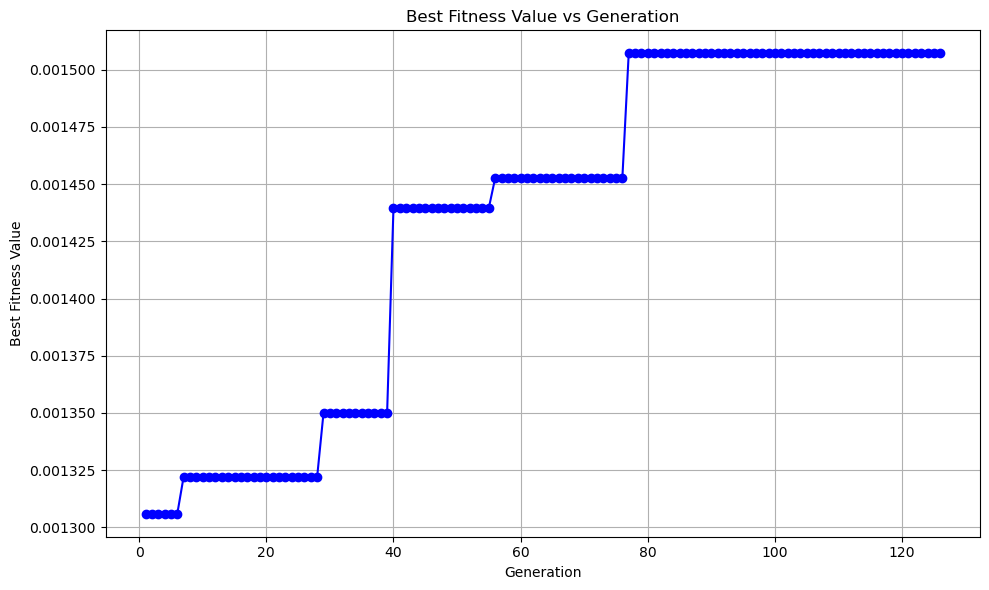

In [6]:
import random
import math
import matplotlib.pyplot as plt

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]
    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

def fitness_function(total_distance):
    if total_distance == 0:
        return float('inf')  # Best possible
    return 1 / total_distance

def store_best_chromosomes(generation, chromosome_fitness, best_chromosomes):
    best = chromosome_fitness[0]
    best_chromosomes.append({
        'generation': generation,
        'chromosome': best['chromosome'],
        'fitness': best['fitness']
    })

def plot_fitness_vs_generation(best_chromosomes):
    generations = [entry['generation'] for entry in best_chromosomes]
    fitness_values = [entry['fitness'] for entry in best_chromosomes]
    plt.figure(figsize=(10, 6))
    plt.plot(generations, fitness_values, marker='o', linestyle='-', color='b')
    plt.title('Best Fitness Value vs Generation')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def genetic_algorithm():
    num_customers = int(input("Enter the number of customers: "))
    num_vehicles = int(input("Enter the number of vehicles: "))
    customers = []
    demands = []
    coordinates = []
    for i in range(1, num_customers + 1):
        demand = int(input(f"Enter demand for customer {i}: "))
        x = float(input(f"Enter x-coordinate for customer {i}: "))
        y = float(input(f"Enter y-coordinate for customer {i}: "))
        customers.append(i)
        demands.append(demand)
        coordinates.append((x, y))
    vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]
    truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
    population_size = int(input("Enter the population size: "))
    max_unchanged = int(input("Enter the number of generations with unchanged fitness before stopping: "))

    crossover_prob = float(input("Enter crossover probability (e.g., 0.8): "))
    elitism_rate = float(input("Enter elitism rate (e.g., 0.9): "))
    mutation_prob = float(input("Enter mutation probability (e.g., 0.2): "))

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            if chrom not in population:
                population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    best_chromosomes = []
    unchanged_count = 0
    prev_best_fitness = None
    generation = 0

    while unchanged_count < max_unchanged:
        generation += 1
        chromosome_fitness = []
        for chrom in population:
            assignments = parse_chromosome(chrom, vehicles)
            vehicle_distances = calculate_vehicle_distances(
                assignments, customers, demands, vehicles, coordinates
            )
            total_distance = sum(vehicle_distances[v] for v in vehicles)
            fitness = fitness_function(total_distance)
            chromosome_fitness.append({
                'chromosome': chrom,
                'assignments': assignments,
                'vehicle_distances': vehicle_distances,
                'total_distance': total_distance,
                'fitness': fitness
            })
        chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)
        population = [cd['chromosome'] for cd in chromosome_fitness]

        store_best_chromosomes(generation, chromosome_fitness, best_chromosomes)

        current_best_fitness = chromosome_fitness[0]['fitness']
        if prev_best_fitness is not None and abs(current_best_fitness - prev_best_fitness) < 1e-10:
            unchanged_count += 1
        else:
            unchanged_count = 1
            prev_best_fitness = current_best_fitness

        elitism_count = int(population_size * elitism_rate)
        next_population = population[:elitism_count]
        prev_generation = population[:]

        while len(next_population) < population_size:
            if random.random() < crossover_prob:
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                child1, child2 = random.sample(population, 2)
            if random.random() < mutation_prob:
                child1 = swap_mutation(child1)
            if random.random() < mutation_prob:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)

            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                if child1 not in next_population:
                    next_population.append(child1)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    if child2 not in next_population:
                        next_population.append(child2)

        seen = set(tuple(chrom) for chrom in next_population[:elitism_count])
        unique_population = next_population[:elitism_count]
        i = elitism_count
        while i < len(next_population):
            chrom_tuple = tuple(next_population[i])
            if chrom_tuple not in seen:
                unique_population.append(next_population[i])
                seen.add(chrom_tuple)
            else:
                replaced = False
                for candidate in prev_generation[elitism_count:]:
                    cand_tuple = tuple(candidate)
                    if cand_tuple not in seen:
                        unique_population.append(candidate)
                        seen.add(cand_tuple)
                        replaced = True
                        break
            i += 1
        while len(unique_population) < population_size:
            candidate = random.choice(prev_generation[elitism_count:])
            cand_tuple = tuple(candidate)
            if cand_tuple not in seen:
                unique_population.append(candidate)
                seen.add(cand_tuple)
        population = unique_population[:population_size]

    chromosome_fitness = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        fitness = fitness_function(total_distance)
        chromosome_fitness.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance,
            'fitness': fitness
        })

    chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)

    print("\nRanked Chromosomes by Fitness (Reciprocal of Total Distance):")
    for rank, chrom_info in enumerate(chromosome_fitness, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        print(f"  Fitness Value: {chrom_info['fitness']:.6f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

    print("\nBest Chromosome and Fitness Value of Each Generation:")
    for entry in best_chromosomes:
        print(f"Generation {entry['generation']}: Chromosome = {entry['chromosome']}, Fitness = {entry['fitness']:.6f}")

    # Plot the fitness vs. generation graph
    plot_fitness_vs_generation(best_chromosomes)

if __name__ == "__main__":
    genetic_algorithm()


Enter the number of customers:  30
Enter the number of vehicles:  27
Enter demand for customer 1:  400
Enter x-coordinate for customer 1:  678
Enter y-coordinate for customer 1:  895
Enter demand for customer 2:  57
Enter x-coordinate for customer 2:  567
Enter y-coordinate for customer 2:  -88
Enter demand for customer 3:  111
Enter x-coordinate for customer 3:  -3
Enter y-coordinate for customer 3:  -782
Enter demand for customer 4:  44
Enter x-coordinate for customer 4:  23
Enter y-coordinate for customer 4:  234
Enter demand for customer 5:  88
Enter x-coordinate for customer 5:  -44
Enter y-coordinate for customer 5:  55
Enter demand for customer 6:  76
Enter x-coordinate for customer 6:  -9
Enter y-coordinate for customer 6:  34
Enter demand for customer 7:  88
Enter x-coordinate for customer 7:  542
Enter y-coordinate for customer 7:  564
Enter demand for customer 8:  789
Enter x-coordinate for customer 8:  12
Enter y-coordinate for customer 8:  -67
Enter demand for customer 9: 


Ranked Chromosomes by Fitness (Reciprocal of Total Distance):

Rank 1:
  Chromosome: ['11', '20', '1', '7', '25', '24', '10', '33', '17', '16', '6', '21', '30', '35', '18', '14', '54', '27', '9', '53', '19', '36', '26', '4', '23', '12', '8', '15', '41', '47', '57', '29', '56', '38', '55', '40', '44', '43', '13', '2', '3', '5', '37', '50', '39', '46', '49', '48', '32', '45', '51', '52', '42', '34', '22', '28', '31']
    Vehicle 31 serves: ['22', '28']
    Vehicle 32 serves: []
    Vehicle 33 serves: ['11', '20', '1', '7', '25', '24', '10']
    Vehicle 34 serves: []
    Vehicle 35 serves: ['17', '16', '6', '21', '30']
    Vehicle 36 serves: ['19']
    Vehicle 37 serves: ['13', '2', '3', '5']
    Vehicle 38 serves: []
    Vehicle 39 serves: []
    Vehicle 40 serves: []
    Vehicle 41 serves: ['26', '4', '23', '12', '8', '15']
    Vehicle 42 serves: []
    Vehicle 43 serves: []
    Vehicle 44 serves: []
    Vehicle 45 serves: []
    Vehicle 46 serves: []
    Vehicle 47 serves: []
    Vehi

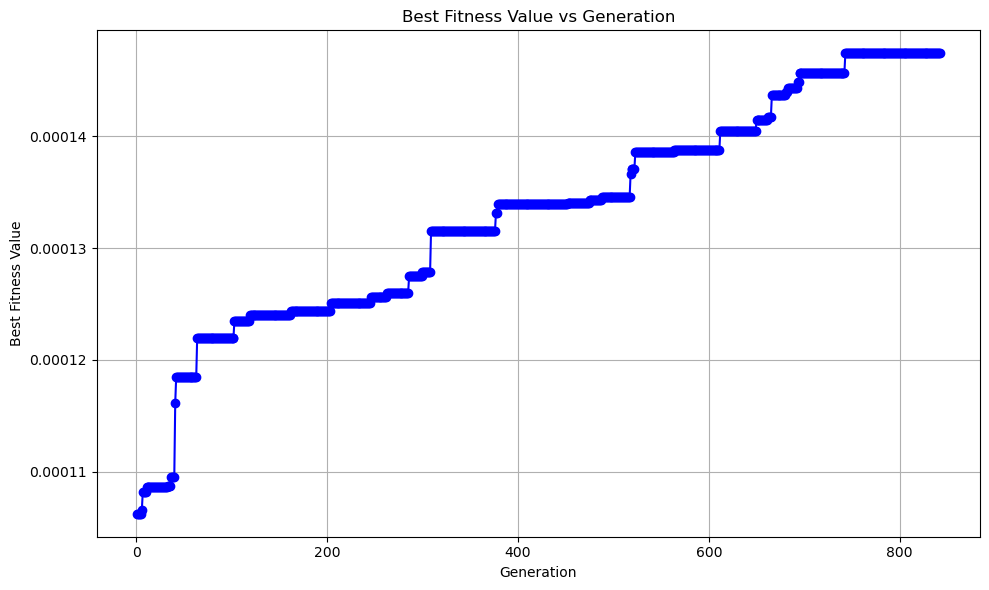

In [1]:
import random
import math
import matplotlib.pyplot as plt

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]
    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

def fitness_function(total_distance):
    if total_distance == 0:
        return float('inf')  # Best possible
    return 1 / total_distance

def store_best_chromosomes(generation, chromosome_fitness, best_chromosomes):
    best = chromosome_fitness[0]
    best_chromosomes.append({
        'generation': generation,
        'chromosome': best['chromosome'],
        'fitness': best['fitness']
    })

def plot_fitness_vs_generation(best_chromosomes):
    generations = [entry['generation'] for entry in best_chromosomes]
    fitness_values = [entry['fitness'] for entry in best_chromosomes]
    plt.figure(figsize=(10, 6))
    plt.plot(generations, fitness_values, marker='o', linestyle='-', color='b')
    plt.title('Best Fitness Value vs Generation')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def genetic_algorithm():
    num_customers = int(input("Enter the number of customers: "))
    num_vehicles = int(input("Enter the number of vehicles: "))
    customers = []
    demands = []
    coordinates = []
    for i in range(1, num_customers + 1):
        demand = int(input(f"Enter demand for customer {i}: "))
        x = float(input(f"Enter x-coordinate for customer {i}: "))
        y = float(input(f"Enter y-coordinate for customer {i}: "))
        customers.append(i)
        demands.append(demand)
        coordinates.append((x, y))
    vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]
    truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
    population_size = int(input("Enter the population size: "))
    max_unchanged = int(input("Enter the number of generations with unchanged fitness before stopping: "))

    crossover_prob = float(input("Enter crossover probability (e.g., 0.8): "))
    elitism_rate = float(input("Enter elitism rate (e.g., 0.9): "))
    mutation_prob = float(input("Enter mutation probability (e.g., 0.2): "))

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            if chrom not in population:
                population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    best_chromosomes = []
    unchanged_count = 0
    prev_best_fitness = None
    generation = 0

    while unchanged_count < max_unchanged:
        generation += 1
        chromosome_fitness = []
        for chrom in population:
            assignments = parse_chromosome(chrom, vehicles)
            vehicle_distances = calculate_vehicle_distances(
                assignments, customers, demands, vehicles, coordinates
            )
            total_distance = sum(vehicle_distances[v] for v in vehicles)
            fitness = fitness_function(total_distance)
            chromosome_fitness.append({
                'chromosome': chrom,
                'assignments': assignments,
                'vehicle_distances': vehicle_distances,
                'total_distance': total_distance,
                'fitness': fitness
            })
        chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)
        population = [cd['chromosome'] for cd in chromosome_fitness]

        store_best_chromosomes(generation, chromosome_fitness, best_chromosomes)

        current_best_fitness = chromosome_fitness[0]['fitness']
        if prev_best_fitness is not None and abs(current_best_fitness - prev_best_fitness) < 1e-10:
            unchanged_count += 1
        else:
            unchanged_count = 1
            prev_best_fitness = current_best_fitness

        elitism_count = int(population_size * elitism_rate)
        next_population = population[:elitism_count]
        prev_generation = population[:]

        while len(next_population) < population_size:
            if random.random() < crossover_prob:
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                child1, child2 = random.sample(population, 2)
            if random.random() < mutation_prob:
                child1 = swap_mutation(child1)
            if random.random() < mutation_prob:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)

            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                if child1 not in next_population:
                    next_population.append(child1)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    if child2 not in next_population:
                        next_population.append(child2)

        seen = set(tuple(chrom) for chrom in next_population[:elitism_count])
        unique_population = next_population[:elitism_count]
        i = elitism_count
        while i < len(next_population):
            chrom_tuple = tuple(next_population[i])
            if chrom_tuple not in seen:
                unique_population.append(next_population[i])
                seen.add(chrom_tuple)
            else:
                replaced = False
                for candidate in prev_generation[elitism_count:]:
                    cand_tuple = tuple(candidate)
                    if cand_tuple not in seen:
                        unique_population.append(candidate)
                        seen.add(cand_tuple)
                        replaced = True
                        break
            i += 1
        while len(unique_population) < population_size:
            candidate = random.choice(prev_generation[elitism_count:])
            cand_tuple = tuple(candidate)
            if cand_tuple not in seen:
                unique_population.append(candidate)
                seen.add(cand_tuple)
        population = unique_population[:population_size]

    chromosome_fitness = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        fitness = fitness_function(total_distance)
        chromosome_fitness.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance,
            'fitness': fitness
        })

    chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)

    print("\nRanked Chromosomes by Fitness (Reciprocal of Total Distance):")
    for rank, chrom_info in enumerate(chromosome_fitness, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        print(f"  Fitness Value: {chrom_info['fitness']:.6f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

    print("\nBest Chromosome and Fitness Value of Each Generation:")
    for entry in best_chromosomes:
        print(f"Generation {entry['generation']}: Chromosome = {entry['chromosome']}, Fitness = {entry['fitness']:.6f}")

    # Plot the fitness vs. generation graph
    plot_fitness_vs_generation(best_chromosomes)

if __name__ == "__main__":
    genetic_algorithm()

Enter the number of customers:  40
Enter the number of vehicles:  34
Enter demand for customer 1:  233
Enter x-coordinate for customer 1:  43
Enter y-coordinate for customer 1:  564
Enter demand for customer 2:  34
Enter x-coordinate for customer 2:  543
Enter y-coordinate for customer 2:  4
Enter demand for customer 3:  45
Enter x-coordinate for customer 3:  -45
Enter y-coordinate for customer 3:  45
Enter demand for customer 4:  56
Enter x-coordinate for customer 4:  567
Enter y-coordinate for customer 4:  54
Enter demand for customer 5:  32
Enter x-coordinate for customer 5:  54
Enter y-coordinate for customer 5:  56
Enter demand for customer 6:  56
Enter x-coordinate for customer 6:  32
Enter y-coordinate for customer 6:  67
Enter demand for customer 7:  23
Enter x-coordinate for customer 7:  67
Enter y-coordinate for customer 7:  23
Enter demand for customer 8:  567
Enter x-coordinate for customer 8:  23
Enter y-coordinate for customer 8:  55
Enter demand for customer 9:  43
Enter


Ranked Chromosomes by Fitness (Reciprocal of Total Distance):

Rank 1:
  Chromosome: ['40', '24', '4', '31', '14', '22', '1', '29', '23', '2', '27', '46', '15', '35', '13', '64', '11', '30', '39', '3', '34', '32', '36', '65', '10', '7', '17', '9', '19', '8', '26', '72', '37', '12', '38', '25', '20', '16', '28', '5', '33', '6', '18', '48', '66', '47', '71', '62', '43', '56', '49', '70', '67', '41', '42', '52', '74', '44', '69', '68', '45', '53', '57', '58', '61', '50', '21', '54', '59', '60', '63', '73', '55', '51']
    Vehicle 41 serves: []
    Vehicle 42 serves: []
    Vehicle 43 serves: []
    Vehicle 44 serves: []
    Vehicle 45 serves: []
    Vehicle 46 serves: ['40', '24', '4', '31', '14', '22', '1', '29', '23', '2', '27']
    Vehicle 47 serves: []
    Vehicle 48 serves: ['37', '12', '38', '25', '20', '16', '28', '5', '33', '6', '18']
    Vehicle 49 serves: []
    Vehicle 50 serves: []
    Vehicle 51 serves: []
    Vehicle 52 serves: []
    Vehicle 53 serves: []
    Vehicle 54 se

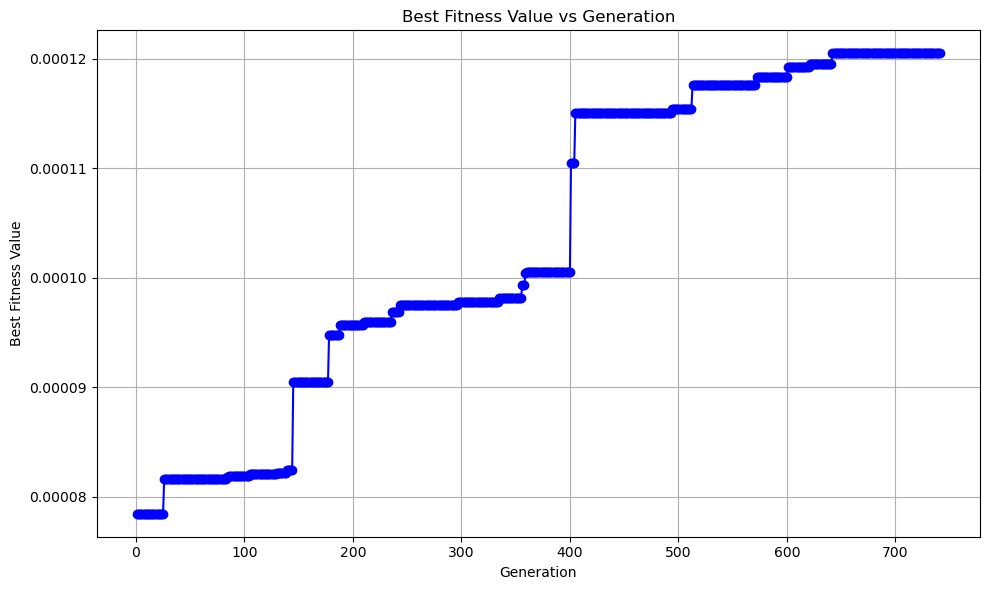

In [4]:
import random
import math
import matplotlib.pyplot as plt

def split_customer_demand(customer_id, demand, capacity):
    splits = []
    while demand > capacity:
        splits.append((f"{customer_id}p{len(splits)+1}", capacity))
        demand -= capacity
    if demand > 0:
        splits.append((f"{customer_id}p{len(splits)+1}", demand))
    return splits

def get_customer_parts(customers, demands, capacity):
    customer_parts = []
    demand_parts = []
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                customer_parts.append(label)
                demand_parts.append(part_demand)
        else:
            customer_parts.append(str(c))
            demand_parts.append(d)
    return customer_parts, demand_parts

def build_demands_dict(customers, demands, capacity):
    demands_dict = {}
    for c, d in zip(customers, demands):
        if d > capacity:
            splits = split_customer_demand(c, d, capacity)
            for label, part_demand in splits:
                demands_dict[label] = part_demand
        else:
            demands_dict[str(c)] = d
    return demands_dict

def generate_random_chromosome(customer_parts, demand_parts, vehicles, capacity):
    unassigned = list(zip(customer_parts, demand_parts))
    random.shuffle(unassigned)
    vehicles_left = vehicles[:]
    random.shuffle(vehicles_left)
    chromosome = []
    used_vehicles = set()
    i = 0
    n = len(unassigned)
    while i < n and vehicles_left:
        v = vehicles_left.pop()
        used_vehicles.add(v)
        group = []
        load = 0
        while i < n and load + unassigned[i][1] <= capacity:
            group.append(unassigned[i][0])
            load += unassigned[i][1]
            i += 1
        if group:
            chromosome.extend(group)
            chromosome.append(str(v))
    if i < n:
        return None
    for v in vehicles:
        if v not in used_vehicles:
            chromosome.append(str(v))
    return chromosome

def parse_chromosome(chromosome, vehicles):
    vehicle_set = set(str(v) for v in vehicles)
    assignments = {v: [] for v in vehicles}
    i = 0
    n = len(chromosome)
    while i < n:
        group = []
        while i < n and chromosome[i] not in vehicle_set:
            group.append(chromosome[i])
            i += 1
        if i < n and chromosome[i] in vehicle_set:
            v = int(chromosome[i])
            assignments[v].extend(group)
            i += 1
    return assignments

def is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, capacity):
    assigned_customers = set()
    assignments = parse_chromosome(chrom, vehicles)
    for v, cust_list in assignments.items():
        total_load = 0
        for cust in cust_list:
            if cust not in customer_parts or cust in assigned_customers:
                return False
            assigned_customers.add(cust)
            total_load += demands_dict[cust]
        if total_load > capacity:
            return False
    if assigned_customers != set(customer_parts):
        return False
    if len(chrom) != len(set(chrom)):
        return False
    if not all(str(v) in chrom for v in vehicles):
        return False
    return True

def calculate_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_vehicle_distances(assignments, customers, demands, vehicles, coordinates, depot=(0, 0)):
    cust_part_coords = {}
    for i, c in enumerate(customers):
        cust_part_coords[str(c)] = coordinates[i]
    for i, c in enumerate(customers):
        for part_num in range(2, 20):
            cust_part_coords[f"{c}p{part_num}"] = coordinates[i]
    vehicle_distances = {}
    for v, cust_list in assignments.items():
        if not cust_list:
            vehicle_distances[v] = 0.0
            continue
        total_dist = 0.0
        prev_point = depot
        for cust in cust_list:
            total_dist += calculate_distance(prev_point, cust_part_coords[cust])
            prev_point = cust_part_coords[cust]
        total_dist += calculate_distance(prev_point, depot)
        vehicle_distances[v] = total_dist
    return vehicle_distances

def single_point_crossover(parent1, parent2):
    length = len(parent1)
    if length < 2:
        return parent1[:], parent2[:]
    point = random.randint(1, length - 2)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def swap_mutation(chrom):
    c = chrom[:]
    idx1, idx2 = random.sample(range(len(c)), 2)
    c[idx1], c[idx2] = c[idx2], c[idx1]
    return c

def repair_chromosome(chrom, customer_parts, vehicles):
    seen = set()
    new_chrom = []
    for gene in chrom:
        if gene not in seen:
            new_chrom.append(gene)
            seen.add(gene)
    all_numbers = set(customer_parts + [str(v) for v in vehicles])
    missing = all_numbers - set(new_chrom)
    new_chrom += list(missing)
    return new_chrom[:len(customer_parts) + len(vehicles)]

def fitness_function(total_distance):
    if total_distance == 0:
        return float('inf')  # Best possible
    return 1 / total_distance

def store_best_chromosomes(generation, chromosome_fitness, best_chromosomes):
    best = chromosome_fitness[0]
    best_chromosomes.append({
        'generation': generation,
        'chromosome': best['chromosome'],
        'fitness': best['fitness']
    })

def plot_fitness_vs_generation(best_chromosomes):
    generations = [entry['generation'] for entry in best_chromosomes]
    fitness_values = [entry['fitness'] for entry in best_chromosomes]
    plt.figure(figsize=(10, 6))
    plt.plot(generations, fitness_values, marker='o', linestyle='-', color='b')
    plt.title('Best Fitness Value vs Generation')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def genetic_algorithm():
    num_customers = int(input("Enter the number of customers: "))
    num_vehicles = int(input("Enter the number of vehicles: "))
    customers = []
    demands = []
    coordinates = []
    for i in range(1, num_customers + 1):
        demand = int(input(f"Enter demand for customer {i}: "))
        x = float(input(f"Enter x-coordinate for customer {i}: "))
        y = float(input(f"Enter y-coordinate for customer {i}: "))
        customers.append(i)
        demands.append(demand)
        coordinates.append((x, y))
    vehicles = [i + num_customers for i in range(1, num_vehicles + 1)]
    truck_capacity = int(input("Enter the load carrying capacity of each truck: "))
    population_size = int(input("Enter the population size: "))
    max_unchanged = int(input("Enter the number of generations with unchanged fitness before stopping: "))

    crossover_prob = float(input("Enter crossover probability (e.g., 0.8): "))
    elitism_rate = float(input("Enter elitism rate (e.g., 0.9): "))
    mutation_prob = float(input("Enter mutation probability (e.g., 0.2): "))

    customer_parts, demand_parts = get_customer_parts(customers, demands, truck_capacity)
    demands_dict = build_demands_dict(customers, demands, truck_capacity)

    population = []
    attempts = 0
    while len(population) < population_size and attempts < population_size * 100:
        chrom = generate_random_chromosome(customer_parts, demand_parts, vehicles, truck_capacity)
        if chrom and is_legitimate_chromosome(chrom, customer_parts, vehicles, demands_dict, truck_capacity):
            if chrom not in population:
                population.append(chrom)
        attempts += 1

    if len(population) < population_size:
        print("Could not generate enough legitimate chromosomes for initial population.")
        return

    best_chromosomes = []
    unchanged_count = 0
    prev_best_fitness = None
    generation = 0

    while unchanged_count < max_unchanged:
        generation += 1
        chromosome_fitness = []
        for chrom in population:
            assignments = parse_chromosome(chrom, vehicles)
            vehicle_distances = calculate_vehicle_distances(
                assignments, customers, demands, vehicles, coordinates
            )
            total_distance = sum(vehicle_distances[v] for v in vehicles)
            fitness = fitness_function(total_distance)
            chromosome_fitness.append({
                'chromosome': chrom,
                'assignments': assignments,
                'vehicle_distances': vehicle_distances,
                'total_distance': total_distance,
                'fitness': fitness
            })
        chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)
        population = [cd['chromosome'] for cd in chromosome_fitness]

        store_best_chromosomes(generation, chromosome_fitness, best_chromosomes)

        current_best_fitness = chromosome_fitness[0]['fitness']
        if prev_best_fitness is not None and abs(current_best_fitness - prev_best_fitness) < 1e-10:
            unchanged_count += 1
        else:
            unchanged_count = 1
            prev_best_fitness = current_best_fitness

        elitism_count = int(population_size * elitism_rate)
        next_population = population[:elitism_count]
        prev_generation = population[:]

        while len(next_population) < population_size:
            if random.random() < crossover_prob:
                parent1, parent2 = random.sample(population, 2)
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                child1, child2 = random.sample(population, 2)
            if random.random() < mutation_prob:
                child1 = swap_mutation(child1)
            if random.random() < mutation_prob:
                child2 = swap_mutation(child2)
            child1 = repair_chromosome(child1, customer_parts, vehicles)
            child2 = repair_chromosome(child2, customer_parts, vehicles)

            if is_legitimate_chromosome(child1, customer_parts, vehicles, demands_dict, truck_capacity):
                if child1 not in next_population:
                    next_population.append(child1)
            if len(next_population) < population_size:
                if is_legitimate_chromosome(child2, customer_parts, vehicles, demands_dict, truck_capacity):
                    if child2 not in next_population:
                        next_population.append(child2)

        seen = set(tuple(chrom) for chrom in next_population[:elitism_count])
        unique_population = next_population[:elitism_count]
        i = elitism_count
        while i < len(next_population):
            chrom_tuple = tuple(next_population[i])
            if chrom_tuple not in seen:
                unique_population.append(next_population[i])
                seen.add(chrom_tuple)
            else:
                replaced = False
                for candidate in prev_generation[elitism_count:]:
                    cand_tuple = tuple(candidate)
                    if cand_tuple not in seen:
                        unique_population.append(candidate)
                        seen.add(cand_tuple)
                        replaced = True
                        break
            i += 1
        while len(unique_population) < population_size:
            candidate = random.choice(prev_generation[elitism_count:])
            cand_tuple = tuple(candidate)
            if cand_tuple not in seen:
                unique_population.append(candidate)
                seen.add(cand_tuple)
        population = unique_population[:population_size]

    chromosome_fitness = []
    for chrom in population:
        assignments = parse_chromosome(chrom, vehicles)
        vehicle_distances = calculate_vehicle_distances(
            assignments, customers, demands, vehicles, coordinates
        )
        total_distance = sum(vehicle_distances[v] for v in vehicles)
        fitness = fitness_function(total_distance)
        chromosome_fitness.append({
            'chromosome': chrom,
            'assignments': assignments,
            'vehicle_distances': vehicle_distances,
            'total_distance': total_distance,
            'fitness': fitness
        })

    chromosome_fitness.sort(key=lambda x: x['fitness'], reverse=True)

    print("\nRanked Chromosomes by Fitness (Reciprocal of Total Distance):")
    for rank, chrom_info in enumerate(chromosome_fitness, 1):
        print(f"\nRank {rank}:")
        print(f"  Chromosome: {chrom_info['chromosome']}")
        for v in vehicles:
            print(f"    Vehicle {v} serves: {chrom_info['assignments'][v]}")
        print(f"  Total Distance: {chrom_info['total_distance']:.2f}")
        print(f"  Fitness Value: {chrom_info['fitness']:.6f}")
        for v in vehicles:
            print(f"    Vehicle {v} distance: {chrom_info['vehicle_distances'][v]:.2f}")

    print("\nCustomer Coordinates:")
    for i, coord in enumerate(coordinates, 1):
        print(f"Customer {i}: {coord}")

    print("\nBest Chromosome and Fitness Value of Each Generation:")
    for entry in best_chromosomes:
        print(f"Generation {entry['generation']}: Chromosome = {entry['chromosome']}, Fitness = {entry['fitness']:.6f}")

    # Plot the fitness vs. generation graph
    plot_fitness_vs_generation(best_chromosomes)

if __name__ == "__main__":
    genetic_algorithm()